# End-to-End notebook for training Latent Diffusion Model (LDM)

This is a stripped down version of the full code from "Latent diffusion model" code (https://github.com/CompVis/latent-diffusion). This notebook version was created by me for use in the 2022 Deep Learning coursework by Chris Willocks.

In the LDM paper they experiment between two different regularisation methods for auto-encoders: KL-reg which uses a KL penalty and VQ-reg which uses vector quantisation. VQ-reg doesn't improve image quality much for small images and instead just overcomplicate things, so we stick with KL.

(this was trained on a 4090 and as such expects 24GB of VRAM. If you do not have that much VRAM it may be neccessary to reduce batch sizes accordingly)

## Requirements

In [1]:
# !pip install taming-transformers
# !pip install tensorboard==1.14.0
# !pip install numpy
# !pip install torch
# !pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu117
# !pip install pytorch_lightning
# !pip install tqdm
# !pip install easydict
# !pip install opencv-python

## Imports

In [2]:
import importlib
# utility libraries
import math
import os
from abc import abstractmethod
# Diffusion model
from contextlib import contextmanager
from functools import partial

import numpy as np
# pytorch_lightning imports
import pytorch_lightning as pl
# torch imports
import torch
import torch as th
import torch.nn.functional as F
import torchvision
from einops import rearrange, repeat
from matplotlib import pyplot as plt
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from torch import nn, einsum
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import DataLoader, TensorDataset
from torchvision.transforms import (CenterCrop, Compose, Resize, ToTensor)
from tqdm import tqdm

## Setup

This code assumes you have access to a GPU with at least 24GB of memory but if you don't you will need to reduce the batch-size in Setup (4 will work for most gpus)

In [3]:
img_size = 128
batch_size = 24
dataset_name = "ffhq"
DATASET_DIR = f"../datasets/{dataset_name}"
transform = Compose([
    Resize(img_size),
    CenterCrop(img_size),
    ToTensor()
])
dataset = torchvision.datasets.ImageFolder(DATASET_DIR, transform=transform)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=8)

torch.set_float32_matmul_precision('medium')

In [4]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 4090 (UUID: GPU-e7e85714-8fc6-db83-602a-5dddddb03c51)


## LDM utility functions

In [5]:
def count_params(model, verbose=False):
    total_params = sum(p.numel() for p in model.parameters())
    if verbose:
        print(f"{model.__class__.__name__} has {total_params * 1.e-6:.2f} M params.")
    return total_params


def instantiate_from_config(config):
    if not "target" in config:
        if config == '__is_first_stage__':
            return None
        elif config == "__is_unconditional__":
            return None
        raise KeyError("Expected key `target` to instantiate.")
    return get_obj_from_str(config["target"])(**config.get("params", dict()))


def get_obj_from_str(string, reload=False):
    module, cls = string.rsplit(".", 1)
    if reload:
        module_imp = importlib.import_module(module)
        importlib.reload(module_imp)
    return getattr(importlib.import_module(module, package=None), cls)

### Distributions

In [6]:
def normal_kl(mean1, logvar1, mean2, logvar2):
    """
    source: https://github.com/openai/guided-diffusion/blob/27c20a8fab9cb472df5d6bdd6c8d11c8f430b924/guided_diffusion/losses.py#L12
    Compute the KL divergence between two gaussians.
    Shapes are automatically broadcasted, so batches can be compared to
    scalars, among other use cases.
    """
    tensor = None
    for obj in (mean1, logvar1, mean2, logvar2):
        if isinstance(obj, torch.Tensor):
            tensor = obj
            break
    assert tensor is not None, "at least one argument must be a Tensor"

    # Force variances to be Tensors. Broadcasting helps convert scalars to
    # Tensors, but it does not work for torch.exp().
    logvar1, logvar2 = [
        x if isinstance(x, torch.Tensor) else torch.tensor(x).to(tensor)
        for x in (logvar1, logvar2)
    ]

    return 0.5 * (
            -1.0
            + logvar2
            - logvar1
            + torch.exp(logvar1 - logvar2)
            + ((mean1 - mean2) ** 2) * torch.exp(-logvar2)
    )


class DiagonalGaussianDistribution(object):
    def __init__(self, parameters, deterministic=False):
        self.parameters = parameters
        self.mean, self.logvar = torch.chunk(parameters, 2, dim=1)
        self.logvar = torch.clamp(self.logvar, -30.0, 20.0)
        self.deterministic = deterministic
        self.std = torch.exp(0.5 * self.logvar)
        self.var = torch.exp(self.logvar)
        if self.deterministic:
            self.var = self.std = torch.zeros_like(self.mean).to(device=self.parameters.device)

    def sample(self):
        x = self.mean + self.std * torch.randn(self.mean.shape).to(device=self.parameters.device)
        return x

    def kl(self, other=None):
        if self.deterministic:
            return torch.Tensor([0.])
        else:
            if other is None:
                return 0.5 * torch.sum(torch.pow(self.mean, 2)
                                       + self.var - 1.0 - self.logvar,
                                       dim=[1, 2, 3])
            else:
                return 0.5 * torch.sum(
                    torch.pow(self.mean - other.mean, 2) / other.var
                    + self.var / other.var - 1.0 - self.logvar + other.logvar,
                    dim=[1, 2, 3])

    def nll(self, sample, dims=[1, 2, 3]):
        if self.deterministic:
            return torch.Tensor([0.])
        logtwopi = np.log(2.0 * np.pi)
        return 0.5 * torch.sum(
            logtwopi + self.logvar + torch.pow(sample - self.mean, 2) / self.var,
            dim=dims)

    def mode(self):
        return self.mean

## KL Autoencoder

### 1. Autoencoder utility functions

In [7]:
def nonlinearity(x):
    # swish
    return x * torch.sigmoid(x)


def Normalize(in_channels, num_groups=32):
    return torch.nn.GroupNorm(num_groups=num_groups, num_channels=in_channels, eps=1e-6, affine=True)

### 2. Create resnet block

In [8]:
class ResnetBlock(nn.Module):
    def __init__(self, *, in_channels, out_channels=None, conv_shortcut=False,
                 dropout, temb_channels=512):
        super().__init__()
        self.in_channels = in_channels
        out_channels = in_channels if out_channels is None else out_channels
        self.out_channels = out_channels
        self.use_conv_shortcut = conv_shortcut

        self.norm1 = Normalize(in_channels)
        self.conv1 = torch.nn.Conv2d(in_channels,
                                     out_channels,
                                     kernel_size=3,
                                     stride=1,
                                     padding=1)
        if temb_channels > 0:
            self.temb_proj = torch.nn.Linear(temb_channels,
                                             out_channels)
        self.norm2 = Normalize(out_channels)
        self.dropout = torch.nn.Dropout(dropout)
        self.conv2 = torch.nn.Conv2d(out_channels,
                                     out_channels,
                                     kernel_size=3,
                                     stride=1,
                                     padding=1)
        if self.in_channels != self.out_channels:
            if self.use_conv_shortcut:
                self.conv_shortcut = torch.nn.Conv2d(in_channels,
                                                     out_channels,
                                                     kernel_size=3,
                                                     stride=1,
                                                     padding=1)
            else:
                self.nin_shortcut = torch.nn.Conv2d(in_channels,
                                                    out_channels,
                                                    kernel_size=1,
                                                    stride=1,
                                                    padding=0)

    def forward(self, x, temb):
        h = x
        h = self.norm1(h)
        h = nonlinearity(h)
        h = self.conv1(h)

        if temb is not None:
            h = h + self.temb_proj(nonlinearity(temb))[:, :, None, None]

        h = self.norm2(h)
        h = nonlinearity(h)
        h = self.dropout(h)
        h = self.conv2(h)

        if self.in_channels != self.out_channels:
            if self.use_conv_shortcut:
                x = self.conv_shortcut(x)
            else:
                x = self.nin_shortcut(x)

        return x + h

### 3. Attention block (not needed)

The attention block is needed for cross-attention which is used for conditioning the model on text, however for image generation alone it's really not needed. We leave it in here incase text-to-image is needed in the future

In [9]:
class AttnBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.in_channels = in_channels

        self.norm = Normalize(in_channels)
        self.q = torch.nn.Conv2d(in_channels,
                                 in_channels,
                                 kernel_size=1,
                                 stride=1,
                                 padding=0)
        self.k = torch.nn.Conv2d(in_channels,
                                 in_channels,
                                 kernel_size=1,
                                 stride=1,
                                 padding=0)
        self.v = torch.nn.Conv2d(in_channels,
                                 in_channels,
                                 kernel_size=1,
                                 stride=1,
                                 padding=0)
        self.proj_out = torch.nn.Conv2d(in_channels,
                                        in_channels,
                                        kernel_size=1,
                                        stride=1,
                                        padding=0)

    def forward(self, x):
        h_ = x
        h_ = self.norm(h_)
        q = self.q(h_)
        k = self.k(h_)
        v = self.v(h_)

        # compute attention
        b, c, h, w = q.shape
        q = q.reshape(b, c, h * w)
        q = q.permute(0, 2, 1)  # b,hw,c
        k = k.reshape(b, c, h * w)  # b,c,hw
        w_ = torch.bmm(q, k)  # b,hw,hw    w[b,i,j]=sum_c q[b,i,c]k[b,c,j]
        w_ = w_ * (int(c) ** (-0.5))
        w_ = torch.nn.functional.softmax(w_, dim=2)

        # attend to values
        v = v.reshape(b, c, h * w)
        w_ = w_.permute(0, 2, 1)  # b,hw,hw (first hw of k, second of q)
        h_ = torch.bmm(v, w_)  # b, c,hw (hw of q) h_[b,c,j] = sum_i v[b,c,i] w_[b,i,j]
        h_ = h_.reshape(b, c, h, w)

        h_ = self.proj_out(h_)

        return x + h_

### 4. Encoder
The encoder architecture is:

1. Covolutional layer to change from 3 channels to ch (128) number of channels.
2. two resnet blocks followed by downsample using convolution with stride 2, 3 times. Each time multiply the number of channnels according to ch_mult excluding last variable (1,2,4). The total downsampling factor = 2^len(ch_mult-1)
3. Two more res blocks
4. Resnet, attention, Resnet
5. Normalize and convolution from whatever the final number of channels is (128x1x2x4 = 1024) to the number of channels we want to have in the latent space (z_channel = 4)

* resnet is only used to deepen the model whilst avoiding vanishing gradients
* the way that convolution works is that it will apply the convolution to each channel and sum the result into a 1D vector. It will then apply n number of these convolutions one for each output channel. As such the final convolution combines 1024 layers into 1D vectors and then does this 4 times

In [10]:
class Downsample(nn.Module):
    def __init__(self, in_channels, with_conv):
        super().__init__()
        self.with_conv = with_conv
        if self.with_conv:
            # no asymmetric padding in torch conv, must do it ourselves
            self.conv = torch.nn.Conv2d(in_channels,
                                        in_channels,
                                        kernel_size=3,
                                        stride=2,
                                        padding=0)

    def forward(self, x):
        if self.with_conv:
            pad = (0, 1, 0, 1)
            x = torch.nn.functional.pad(x, pad, mode="constant", value=0)
            x = self.conv(x)
        else:
            x = torch.nn.functional.avg_pool2d(x, kernel_size=2, stride=2)
        return x

In [11]:
class Encoder(nn.Module):
    def __init__(self, *, ch, out_ch, ch_mult=(1, 2, 4, 8), num_res_blocks,
                 attn_resolutions, dropout=0.0, resamp_with_conv=True, in_channels,
                 resolution, z_channels, double_z=True, use_linear_attn=False, attn_type="vanilla",
                 **ignore_kwargs):
        super().__init__()
        if use_linear_attn: attn_type = "linear"
        self.ch = ch
        self.temb_ch = 0
        self.num_resolutions = len(ch_mult)
        self.num_res_blocks = num_res_blocks
        self.resolution = resolution
        self.in_channels = in_channels

        # downsampling
        self.conv_in = torch.nn.Conv2d(in_channels,
                                       self.ch,
                                       kernel_size=3,
                                       stride=1,
                                       padding=1)

        curr_res = resolution
        in_ch_mult = (1,) + tuple(ch_mult)
        self.in_ch_mult = in_ch_mult
        self.down = nn.ModuleList()
        for i_level in range(self.num_resolutions):
            block = nn.ModuleList()
            attn = nn.ModuleList()
            block_in = ch * in_ch_mult[i_level]
            block_out = ch * ch_mult[i_level]
            for i_block in range(self.num_res_blocks):
                block.append(ResnetBlock(in_channels=block_in,
                                         out_channels=block_out,
                                         temb_channels=self.temb_ch,
                                         dropout=dropout))
                block_in = block_out
                if curr_res in attn_resolutions:
                    attn.append(AttnBlock(block_in))
            down = nn.Module()
            down.block = block
            down.attn = attn
            if i_level != self.num_resolutions - 1:
                down.downsample = Downsample(block_in, resamp_with_conv)
                curr_res = curr_res // 2
            self.down.append(down)

        # middle
        self.mid = nn.Module()
        self.mid.block_1 = ResnetBlock(in_channels=block_in,
                                       out_channels=block_in,
                                       temb_channels=self.temb_ch,
                                       dropout=dropout)
        self.mid.attn_1 = AttnBlock(block_in)
        self.mid.block_2 = ResnetBlock(in_channels=block_in,
                                       out_channels=block_in,
                                       temb_channels=self.temb_ch,
                                       dropout=dropout)

        # end
        self.norm_out = Normalize(block_in)
        self.conv_out = torch.nn.Conv2d(block_in,
                                        2 * z_channels if double_z else z_channels,
                                        kernel_size=3,
                                        stride=1,
                                        padding=1)

    def forward(self, x):
        # timestep embedding
        temb = None

        # downsampling
        hs = [self.conv_in(x)]
        for i_level in range(self.num_resolutions):
            for i_block in range(self.num_res_blocks):
                h = self.down[i_level].block[i_block](hs[-1], temb)
                if len(self.down[i_level].attn) > 0:
                    h = self.down[i_level].attn[i_block](h)
                hs.append(h)
            if i_level != self.num_resolutions - 1:
                hs.append(self.down[i_level].downsample(hs[-1]))

        # middle
        h = hs[-1]
        h = self.mid.block_1(h, temb)
        h = self.mid.attn_1(h)
        h = self.mid.block_2(h, temb)

        # end
        h = self.norm_out(h)
        h = nonlinearity(h)
        h = self.conv_out(h)
        return h

### 5. Decoder

In [12]:
class Upsample(nn.Module):
    def __init__(self, in_channels, with_conv):
        super().__init__()
        self.with_conv = with_conv
        if self.with_conv:
            self.conv = torch.nn.Conv2d(in_channels,
                                        in_channels,
                                        kernel_size=3,
                                        stride=1,
                                        padding=1)

    def forward(self, x):
        x = torch.nn.functional.interpolate(x, scale_factor=2.0, mode="nearest")
        if self.with_conv:
            x = self.conv(x)
        return x

In [13]:
class Decoder(nn.Module):
    def __init__(self, *, ch, out_ch, ch_mult=(1, 2, 4, 8), num_res_blocks,
                 attn_resolutions, dropout=0.0, resamp_with_conv=True, in_channels,
                 resolution, z_channels, give_pre_end=False, tanh_out=False, use_linear_attn=False,
                 attn_type="vanilla", **ignorekwargs):
        super().__init__()
        if use_linear_attn: attn_type = "linear"
        self.ch = ch
        self.temb_ch = 0
        self.num_resolutions = len(ch_mult)
        self.num_res_blocks = num_res_blocks
        self.resolution = resolution
        self.in_channels = in_channels
        self.give_pre_end = give_pre_end
        self.tanh_out = tanh_out

        # compute in_ch_mult, block_in and curr_res at lowest res
        in_ch_mult = (1,) + tuple(ch_mult)
        block_in = ch * ch_mult[self.num_resolutions - 1]
        curr_res = resolution // 2 ** (self.num_resolutions - 1)
        self.z_shape = (1, z_channels, curr_res, curr_res)
        print("Working with z of shape {} = {} dimensions.".format(
            self.z_shape, np.prod(self.z_shape)))

        # z to block_in
        self.conv_in = torch.nn.Conv2d(z_channels,
                                       block_in,
                                       kernel_size=3,
                                       stride=1,
                                       padding=1)

        # middle
        self.mid = nn.Module()
        self.mid.block_1 = ResnetBlock(in_channels=block_in,
                                       out_channels=block_in,
                                       temb_channels=self.temb_ch,
                                       dropout=dropout)
        self.mid.attn_1 = AttnBlock(block_in)
        self.mid.block_2 = ResnetBlock(in_channels=block_in,
                                       out_channels=block_in,
                                       temb_channels=self.temb_ch,
                                       dropout=dropout)

        # upsampling
        self.up = nn.ModuleList()
        for i_level in reversed(range(self.num_resolutions)):
            block = nn.ModuleList()
            attn = nn.ModuleList()
            block_out = ch * ch_mult[i_level]
            for i_block in range(self.num_res_blocks + 1):
                block.append(ResnetBlock(in_channels=block_in,
                                         out_channels=block_out,
                                         temb_channels=self.temb_ch,
                                         dropout=dropout))
                block_in = block_out
                if curr_res in attn_resolutions:
                    attn.append(AttnBlock(block_in))
            up = nn.Module()
            up.block = block
            up.attn = attn
            if i_level != 0:
                up.upsample = Upsample(block_in, resamp_with_conv)
                curr_res = curr_res * 2
            self.up.insert(0, up)  # prepend to get consistent order

        # end
        self.norm_out = Normalize(block_in)
        self.conv_out = torch.nn.Conv2d(block_in,
                                        out_ch,
                                        kernel_size=3,
                                        stride=1,
                                        padding=1)

    def forward(self, z):
        #assert z.shape[1:] == self.z_shape[1:]
        self.last_z_shape = z.shape

        # timestep embedding
        temb = None

        # z to block_in
        h = self.conv_in(z)

        # middle
        h = self.mid.block_1(h, temb)
        h = self.mid.attn_1(h)
        h = self.mid.block_2(h, temb)

        # upsampling
        for i_level in reversed(range(self.num_resolutions)):
            for i_block in range(self.num_res_blocks + 1):
                h = self.up[i_level].block[i_block](h, temb)
                if len(self.up[i_level].attn) > 0:
                    h = self.up[i_level].attn[i_block](h)
            if i_level != 0:
                h = self.up[i_level].upsample(h)

        # end
        if self.give_pre_end:
            return h

        h = self.norm_out(h)
        h = nonlinearity(h)
        h = self.conv_out(h)
        if self.tanh_out:
            h = torch.tanh(h)
        return h

### 6. Loss function

We create the KL loss function which will be used. This is LPIPS (Learned Perceptual Image Patch Similarity) which is based on a very deep convolutional network from https://github.com/richzhang/PerceptualSimilarity.

In [14]:
from taming.modules.losses.lpips import LPIPS
from taming.modules.discriminator.model import NLayerDiscriminator, weights_init

In [15]:
def adopt_weight(weight, global_step, threshold=0, value=0.):
    if global_step < threshold:
        weight = value
    return weight


def hinge_d_loss(logits_real, logits_fake):
    loss_real = torch.mean(F.relu(1. - logits_real))
    loss_fake = torch.mean(F.relu(1. + logits_fake))
    d_loss = 0.5 * (loss_real + loss_fake)
    return d_loss


class LPIPSWithDiscriminator(nn.Module):
    def __init__(self, disc_start, logvar_init=0.0, kl_weight=1.0, pixelloss_weight=1.0,
                 disc_num_layers=3, disc_in_channels=3, disc_factor=1.0, disc_weight=1.0,
                 perceptual_weight=1.0, use_actnorm=False, disc_conditional=False):

        super().__init__()
        self.kl_weight = kl_weight
        self.pixel_weight = pixelloss_weight
        self.perceptual_loss = LPIPS().eval()
        self.perceptual_weight = perceptual_weight
        # output log variance
        self.logvar = nn.Parameter(torch.ones(size=()) * logvar_init)

        self.discriminator = NLayerDiscriminator(input_nc=disc_in_channels,
                                                 n_layers=disc_num_layers,
                                                 use_actnorm=use_actnorm
                                                 ).apply(weights_init)
        self.discriminator_iter_start = disc_start
        self.disc_loss = hinge_d_loss
        self.disc_factor = disc_factor
        self.discriminator_weight = disc_weight
        self.disc_conditional = disc_conditional

    def calculate_adaptive_weight(self, nll_loss, g_loss, last_layer=None):
        if last_layer is not None:
            nll_grads = torch.autograd.grad(nll_loss, last_layer, retain_graph=True)[0]
            g_grads = torch.autograd.grad(g_loss, last_layer, retain_graph=True)[0]
        else:
            nll_grads = torch.autograd.grad(nll_loss, self.last_layer[0], retain_graph=True)[0]
            g_grads = torch.autograd.grad(g_loss, self.last_layer[0], retain_graph=True)[0]

        d_weight = torch.norm(nll_grads) / (torch.norm(g_grads) + 1e-4)
        d_weight = torch.clamp(d_weight, 0.0, 1e4).detach()
        d_weight = d_weight * self.discriminator_weight
        return d_weight

    def forward(self, inputs, reconstructions, posteriors, optimizer_idx,
                global_step, last_layer=None, cond=None, split="train",
                weights=None):
        rec_loss = torch.abs(inputs.contiguous() - reconstructions.contiguous())
        if self.perceptual_weight > 0:
            p_loss = self.perceptual_loss(inputs.contiguous(), reconstructions.contiguous())
            rec_loss = rec_loss + self.perceptual_weight * p_loss

        nll_loss = rec_loss / torch.exp(self.logvar) + self.logvar
        weighted_nll_loss = nll_loss
        if weights is not None:
            weighted_nll_loss = weights * nll_loss
        weighted_nll_loss = torch.sum(weighted_nll_loss) / weighted_nll_loss.shape[0]
        nll_loss = torch.sum(nll_loss) / nll_loss.shape[0]
        kl_loss = posteriors.kl()
        kl_loss = torch.sum(kl_loss) / kl_loss.shape[0]

        # now the GAN part
        if optimizer_idx == 0:
            # generator update
            if cond is None:
                assert not self.disc_conditional
                logits_fake = self.discriminator(reconstructions.contiguous())
            else:
                assert self.disc_conditional
                logits_fake = self.discriminator(torch.cat((reconstructions.contiguous(), cond), dim=1))
            g_loss = -torch.mean(logits_fake)

            if self.disc_factor > 0.0:
                try:
                    d_weight = self.calculate_adaptive_weight(nll_loss, g_loss, last_layer=last_layer)
                except RuntimeError:
                    assert not self.training
                    d_weight = torch.tensor(0.0)
            else:
                d_weight = torch.tensor(0.0)

            disc_factor = adopt_weight(self.disc_factor, global_step, threshold=self.discriminator_iter_start)
            loss = weighted_nll_loss + self.kl_weight * kl_loss + d_weight * disc_factor * g_loss

            log = {"{}/total_loss".format(split): loss.clone().detach().mean(),
                   "{}/logvar".format(split): self.logvar.detach(),
                   "{}/kl_loss".format(split): kl_loss.detach().mean(),
                   "{}/nll_loss".format(split): nll_loss.detach().mean(),
                   "{}/rec_loss".format(split): rec_loss.detach().mean(),
                   "{}/d_weight".format(split): d_weight.detach(),
                   "{}/disc_factor".format(split): torch.tensor(disc_factor),
                   "{}/g_loss".format(split): g_loss.detach().mean(),
                   }
            return loss, log

        if optimizer_idx == 1:
            # second pass for discriminator update
            if cond is None:
                logits_real = self.discriminator(inputs.contiguous().detach())
                logits_fake = self.discriminator(reconstructions.contiguous().detach())
            else:
                logits_real = self.discriminator(torch.cat((inputs.contiguous().detach(), cond), dim=1))
                logits_fake = self.discriminator(torch.cat((reconstructions.contiguous().detach(), cond), dim=1))

            disc_factor = adopt_weight(self.disc_factor, global_step, threshold=self.discriminator_iter_start)
            d_loss = disc_factor * self.disc_loss(logits_real, logits_fake)

            log = {"{}/disc_loss".format(split): d_loss.clone().detach().mean(),
                   "{}/logits_real".format(split): logits_real.detach().mean(),
                   "{}/logits_fake".format(split): logits_fake.detach().mean()
                   }
            return d_loss, log

### 7. Autoencoder class

In [16]:
class AutoencoderKL(pl.LightningModule):
    def __init__(self,
                 ddconfig,
                 lossconfig,
                 embed_dim,
                 learning_rate=4.5e-6,
                 steps_per_display_output=500,
                 steps_per_save_output=500
                 ):
        super().__init__()
        self.encoder = Encoder(**ddconfig)
        self.decoder = Decoder(**ddconfig)
        self.loss = lossconfig["target"](**lossconfig["params"])
        assert ddconfig["double_z"]
        self.quant_conv = torch.nn.Conv2d(2 * ddconfig["z_channels"], 2 * embed_dim, 1)
        self.post_quant_conv = torch.nn.Conv2d(embed_dim, ddconfig["z_channels"], 1)
        self.embed_dim = embed_dim
        self.learning_rate = learning_rate
        self.steps_per_display_output = steps_per_display_output
        self.steps_per_save_output = steps_per_save_output

    def encode(self, x):
        h = self.encoder(x)
        moments = self.quant_conv(h)
        posterior = DiagonalGaussianDistribution(moments)
        return posterior

    def decode(self, z):
        z = self.post_quant_conv(z)
        dec = self.decoder(z)
        return dec

    def forward(self, input, sample_posterior=True):
        posterior = self.encode(input)
        if sample_posterior:
            z = posterior.sample()
        else:
            z = posterior.mode()
        dec = self.decode(z)
        return dec, posterior

    def training_step(self, batch, batch_idx, optimizer_idx):
        inputs = self.get_input(batch)

        reconstructions, posterior = self(inputs)

        self.log_images(inputs, reconstructions, self.global_step)

        if optimizer_idx == 0:
            # train encoder+decoder+logvar
            aeloss, log_dict_ae = self.loss(inputs, reconstructions, posterior, optimizer_idx, self.global_step,
                                            last_layer=self.get_last_layer(), split="train")
            self.log("aeloss", aeloss, prog_bar=True, logger=True, on_step=True, on_epoch=True)
            self.log_dict(log_dict_ae, prog_bar=False, logger=True, on_step=True, on_epoch=False)
            return aeloss

        if optimizer_idx == 1:
            # train the discriminator
            discloss, log_dict_disc = self.loss(inputs, reconstructions, posterior, optimizer_idx, self.global_step,
                                                last_layer=self.get_last_layer(), split="train")

            self.log("discloss", discloss, prog_bar=True, logger=True, on_step=True, on_epoch=True)
            self.log_dict(log_dict_disc, prog_bar=False, logger=True, on_step=True, on_epoch=False)
            return discloss

    def validation_step(self, batch, batch_idx):
        inputs = self.get_input(batch)
        reconstructions, posterior = self(inputs)
        aeloss, log_dict_ae = self.loss(inputs, reconstructions, posterior, 0, self.global_step,
                                        last_layer=self.get_last_layer(), split="val")

        discloss, log_dict_disc = self.loss(inputs, reconstructions, posterior, 1, self.global_step,
                                            last_layer=self.get_last_layer(), split="val")

        self.log_images(inputs, reconstructions, self.global_step)

        self.log("val/rec_loss", log_dict_ae["val/rec_loss"])
        self.log_dict(log_dict_ae)
        self.log_dict(log_dict_disc)
        return self.log_dict

    def configure_optimizers(self):
        lr = self.learning_rate
        opt_ae = torch.optim.Adam(list(self.encoder.parameters()) +
                                  list(self.decoder.parameters()) +
                                  list(self.quant_conv.parameters()) +
                                  list(self.post_quant_conv.parameters()),
                                  lr=lr, betas=(0.5, 0.9))
        opt_disc = torch.optim.Adam(self.loss.discriminator.parameters(),
                                    lr=lr, betas=(0.5, 0.9))
        return [opt_ae, opt_disc], []

    def get_last_layer(self):
        return self.decoder.conv_out.weight

    @staticmethod
    def get_input(batch):
        return batch[0].to(memory_format=torch.contiguous_format).float()

    @torch.no_grad()
    def log_images(self, originals, recons, step):
        originals = torch.clamp(originals, 0, 1)
        recons = torch.clamp(recons, 0, 1)
        if step % self.steps_per_display_output == 0:
            grid = torchvision.utils.make_grid(originals)
            self.logger.experiment.add_image('Original Images', grid, step)
            grid = torchvision.utils.make_grid(recons)
            self.logger.experiment.add_image('KLvae Recons', grid, step)

        if step % self.steps_per_save_output == 0:
            log_dir = self.logger.log_dir + "/images"
            os.makedirs(log_dir, exist_ok=True)
            torchvision.utils.save_image(
                recons,
                f"{log_dir}/recons_{step}.png",
                nrow=int(np.sqrt(recons.shape[0])),
                padding=0
            )

### 8. Train autoencoder

In [17]:
# Run this code to start the beautiful tensorboard logging system
# !tensorboard --logdir logs

In [18]:
# training parameters
model_size = 32
resume = True
fit = False
model_name = "KLAutoencoderFFHQ"

if model_size == 32:
    log_name = "disc100k-ch96k-resnum1-f4"
    checkpoint_path = f"{model_name}-{log_name}/checkpoints/last-v3.ckpt"
elif model_size == 16:
    log_name = "disc10k-ch96k-resnum1-f8"
    checkpoint_path = f"{model_name}-{log_name}/checkpoints/last.ckpt"
elif model_size == 8:
    log_name = "disc100k-ch96k-resnum1-f16"
    checkpoint_path =f"{model_name}-{log_name}/checkpoints/last-v3.ckpt"
else:
    raise ValueError("Only model sizes 32,16,8 supported")

print(checkpoint_path)
steps_per_checkpoint = 1000
steps_per_log = 10
steps_per_display_output = 100
steps_per_save_output = 200
learning_rate = 4.5e-5  #default: 4.5e-6

# model parameters

# f = 8, input_channels = 128
# number of downsampling layers is len(ch_mult)-1. So f = 2^len(ch_mult-1) = 2^3 = 8

ddconfig = {
    "double_z": True,
    "resolution": img_size,  # the input image size, we will resize the image at the start to this resolution
    "in_channels": 3,  # the number of colour channels in the input image
    "out_ch": 3,  # the number of colour channels in the output image
    "attn_resolutions": [],
    "dropout": 0.0,
}

if model_size == 32:
    ddconfig = ddconfig | {"ch": 96, "ch_mult": [1, 2, 4], "num_res_blocks": 1, "z_channels": 4}
elif model_size == 16:
    ddconfig = ddconfig | {"ch": 128, "ch_mult": [1, 2, 4, 4], "num_res_blocks": 1, "z_channels": 8}
else:
    ddconfig = ddconfig | {"ch": 96, "ch_mult": [1, 2, 2, 3, 4], "num_res_blocks": 1, "z_channels": 4}

lossconfig = {
    "target": LPIPSWithDiscriminator,
    "params": {
        "disc_start": 10001,  # the discriminator can be kind of annoying. I have considered not using it
        "kl_weight": 0.000001,
        #from the paper "To obtain high-fidelity reconstructions we only use a very small regularization [...] , i.e. we weight the KL term by a factor ∼ 10−6"
        "disc_weight": 0.5
    }
}

# setup trainer
logger = TensorBoardLogger("logs", name=f"{model_name}-{log_name}")
checkpoint_callback = ModelCheckpoint(
    dirpath=f"logs/{model_name}-{log_name}/checkpoints",
    every_n_train_steps=steps_per_checkpoint, save_last=True,
    save_top_k=-1
)
ae_trainer = pl.Trainer(
    precision=16,
    callbacks=[checkpoint_callback],
    default_root_dir=f"logs/{model_name}-{log_name}/checkpoints",
    logger=logger,
    accelerator="gpu",
    devices=1,
    log_every_n_steps=10
)

#train model
autoencoder = AutoencoderKL(
    ddconfig=ddconfig,
    lossconfig=lossconfig,
    embed_dim=4 if model_size == 32 else 8 if model_size == 16 else 4,
    learning_rate=learning_rate,
    steps_per_display_output=steps_per_display_output,
    steps_per_save_output=steps_per_save_output
).to("cuda:0")
checkpoint_path = None if not resume else f"logs/{checkpoint_path}"
if fit:
    ae_trainer.fit(model=autoencoder, ckpt_path=checkpoint_path, train_dataloaders=train_loader)
else:
    checkpoint_dict = torch.load(checkpoint_path)
    autoencoder.load_state_dict(checkpoint_dict["state_dict"])

ModelCheckpoint(save_last=True, save_top_k=-1, monitor=None) will duplicate the last checkpoint saved.
Using 16bit None Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


KLAutoencoderFFHQ-disc100k-ch96k-resnum1-f4/checkpoints/last-v3.ckpt
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.


C:\Users\joecl\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\joecl\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips\vgg.pth


### 9. Generate latent files

Code based on train_sampler from (https://github.com/samb-t/unleashing-transformers)

In [19]:
replace = False
latent_shape = img_size // 2 ** (len(ddconfig["ch_mult"]) - 1)
latents_folder = f'latents_{dataset_name}_{latent_shape}_z={ddconfig["z_channels"]}'
num_batches = len(
    train_loader)  # set this to something lower if you can't be asked to wait for all the latents to be generated ;)

if not os.path.exists(latents_folder) or replace:
    if not replace:
        os.mkdir(latents_folder)
    latent_ids = []
    iterator = iter(train_loader)
    for i in tqdm((range(num_batches))):
        batch = next(iterator)
        x = autoencoder.get_input(batch).to("cuda:0")
        latents = autoencoder.encode(x).sample().detach()  # B, emb_dim, H,
        torch.save(latents, f"{latents_folder}/arr_{i}")

train_loader = None
del train_loader
dataset = None
del dataset

## Diffusion Sampler

This is a notebook implementation of the "Latent Diffusion model" from (https://github.com/CompVis/latent-diffusionn) created by me for use in the 2022 Deep Learning coursework by Chris Willocks.

### 1. Diffusion util functions

from "https://github.com/CompVis/latent-diffusion/blob/main/ldm/modules/diffusionmodules/util.py"

In [20]:
# adopted from
# https://github.com/openai/improved-diffusion/blob/main/improved_diffusion/gaussian_diffusion.py
# and
# https://github.com/lucidrains/denoising-diffusion-pytorch/blob/7706bdfc6f527f58d33f84b7b522e61e6e3164b3/denoising_diffusion_pytorch/denoising_diffusion_pytorch.py
# and
# https://github.com/openai/guided-diffusion/blob/0ba878e517b276c45d1195eb29f6f5f72659a05b/guided_diffusion/nn.py
#
# thanks!


def make_beta_schedule(schedule, n_timestep, linear_start=1e-4, linear_end=2e-2, cosine_s=8e-3):
    if schedule == "linear":
        betas = (
                torch.linspace(linear_start ** 0.5, linear_end ** 0.5, n_timestep, dtype=torch.float64) ** 2
        )

    elif schedule == "cosine":
        timesteps = (
                torch.arange(n_timestep + 1, dtype=torch.float64) / n_timestep + cosine_s
        )
        alphas = timesteps / (1 + cosine_s) * np.pi / 2
        alphas = torch.cos(alphas).pow(2)
        alphas = alphas / alphas[0]
        betas = 1 - alphas[1:] / alphas[:-1]
        betas = np.clip(betas, a_min=0, a_max=0.999)

    elif schedule == "sqrt_linear":
        betas = torch.linspace(linear_start, linear_end, n_timestep, dtype=torch.float64)
    elif schedule == "sqrt":
        betas = torch.linspace(linear_start, linear_end, n_timestep, dtype=torch.float64) ** 0.5
    else:
        raise ValueError(f"schedule '{schedule}' unknown.")
    return betas.numpy()


def make_ddim_timesteps(ddim_discr_method, num_ddim_timesteps, num_ddpm_timesteps, verbose=True):
    if ddim_discr_method == 'uniform':
        c = num_ddpm_timesteps // num_ddim_timesteps
        ddim_timesteps = np.asarray(list(range(0, num_ddpm_timesteps, c)))
    elif ddim_discr_method == 'quad':
        ddim_timesteps = ((np.linspace(0, np.sqrt(num_ddpm_timesteps * .8), num_ddim_timesteps)) ** 2).astype(int)
    else:
        raise NotImplementedError(f'There is no ddim discretization method called "{ddim_discr_method}"')

    # assert ddim_timesteps.shape[0] == num_ddim_timesteps
    # add one to get the final alpha values right (the ones from first scale to data during sampling)
    steps_out = ddim_timesteps + 1
    if verbose:
        print(f'Selected timesteps for ddim sampler: {steps_out}')
    return steps_out


def make_ddim_sampling_parameters(alphacums, ddim_timesteps, eta, verbose=True):
    # select alphas for computing the variance schedule
    alphas = alphacums[ddim_timesteps]
    alphas_prev = np.asarray([alphacums[0]] + alphacums[ddim_timesteps[:-1]].tolist())

    # according the the formula provided in https://arxiv.org/abs/2010.02502
    sigmas = eta * np.sqrt((1 - alphas_prev) / (1 - alphas) * (1 - alphas / alphas_prev))
    if verbose:
        print(f'Selected alphas for ddim sampler: a_t: {alphas}; a_(t-1): {alphas_prev}')
        print(f'For the chosen value of eta, which is {eta}, '
              f'this results in the following sigma_t schedule for ddim sampler {sigmas}')
    return sigmas, alphas, alphas_prev


def betas_for_alpha_bar(num_diffusion_timesteps, alpha_bar, max_beta=0.999):
    """
    Create a beta schedule that discretizes the given alpha_t_bar function,
    which defines the cumulative product of (1-beta) over time from t = [0,1].
    :param num_diffusion_timesteps: the number of betas to produce.
    :param alpha_bar: a lambda that takes an argument t from 0 to 1 and
                      produces the cumulative product of (1-beta) up to that
                      part of the diffusion process.
    :param max_beta: the maximum beta to use; use values lower than 1 to
                     prevent singularities.
    """
    betas = []
    for i in range(num_diffusion_timesteps):
        t1 = i / num_diffusion_timesteps
        t2 = (i + 1) / num_diffusion_timesteps
        betas.append(min(1 - alpha_bar(t2) / alpha_bar(t1), max_beta))
    return np.array(betas)


def extract_into_tensor(a, t, x_shape):
    b, *_ = t.shape
    out = a.gather(-1, t)
    return out.reshape(b, *((1,) * (len(x_shape) - 1)))


def checkpoint(func, inputs, params, flag):
    """
    Evaluate a function without caching intermediate activations, allowing for
    reduced memory at the expense of extra compute in the backward pass.
    :param func: the function to evaluate.
    :param inputs: the argument sequence to pass to `func`.
    :param params: a sequence of parameters `func` depends on but does not
                   explicitly take as arguments.
    :param flag: if False, disable gradient checkpointing.
    """
    if flag:
        args = tuple(inputs) + tuple(params)
        return CheckpointFunction.apply(func, len(inputs), *args)
    else:
        return func(*inputs)


class CheckpointFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, run_function, length, *args):
        ctx.run_function = run_function
        ctx.input_tensors = list(args[:length])
        ctx.input_params = list(args[length:])

        with torch.no_grad():
            output_tensors = ctx.run_function(*ctx.input_tensors)
        return output_tensors

    @staticmethod
    def backward(ctx, *output_grads):
        ctx.input_tensors = [x.detach().requires_grad_(True) for x in ctx.input_tensors]
        with torch.enable_grad():
            # Fixes a bug where the first op in run_function modifies the
            # Tensor storage in place, which is not allowed for detach()'d
            # Tensors.
            shallow_copies = [x.view_as(x) for x in ctx.input_tensors]
            output_tensors = ctx.run_function(*shallow_copies)
        input_grads = torch.autograd.grad(
            output_tensors,
            ctx.input_tensors + ctx.input_params,
            output_grads,
            allow_unused=True,
        )
        del ctx.input_tensors
        del ctx.input_params
        del output_tensors
        return (None, None) + input_grads


def timestep_embedding(timesteps, dim, max_period=10000, repeat_only=False):
    """
    Create sinusoidal timestep embeddings.
    :param timesteps: a 1-D Tensor of N indices, one per batch element.
                      These may be fractional.
    :param dim: the dimension of the output.
    :param max_period: controls the minimum frequency of the embeddings.
    :return: an [N x dim] Tensor of positional embeddings.
    """
    if not repeat_only:
        half = dim // 2
        freqs = torch.exp(
            -math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half
        ).to(device=timesteps.device)
        args = timesteps[:, None].float() * freqs[None]
        embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
        if dim % 2:
            embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
    else:
        embedding = repeat(timesteps, 'b -> b d', d=dim)
    return embedding


def zero_module(module):
    """
    Zero out the parameters of a module and return it.
    """
    for p in module.parameters():
        p.detach().zero_()
    return module


def scale_module(module, scale):
    """
    Scale the parameters of a module and return it.
    """
    for p in module.parameters():
        p.detach().mul_(scale)
    return module


def mean_flat(tensor):
    """
    Take the mean over all non-batch dimensions.
    """
    return tensor.mean(dim=list(range(1, len(tensor.shape))))


def normalization(channels):
    """
    Make a standard normalization layer.
    :param channels: number of input channels.
    :return: an nn.Module for normalization.
    """
    return GroupNorm32(32, channels)


# PyTorch 1.7 has SiLU, but we support PyTorch 1.5.
class SiLU(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)


class GroupNorm32(nn.GroupNorm):
    def forward(self, x):
        return super().forward(x.float()).type(x.dtype)


def conv_nd(dims, *args, **kwargs):
    """
    Create a 1D, 2D, or 3D convolution module.
    """
    if dims == 1:
        return nn.Conv1d(*args, **kwargs)
    elif dims == 2:
        return nn.Conv2d(*args, **kwargs)
    elif dims == 3:
        return nn.Conv3d(*args, **kwargs)
    raise ValueError(f"unsupported dimensions: {dims}")


def linear(*args, **kwargs):
    """
    Create a linear module.
    """
    return nn.Linear(*args, **kwargs)


def avg_pool_nd(dims, *args, **kwargs):
    """
    Create a 1D, 2D, or 3D average pooling module.
    """
    if dims == 1:
        return nn.AvgPool1d(*args, **kwargs)
    elif dims == 2:
        return nn.AvgPool2d(*args, **kwargs)
    elif dims == 3:
        return nn.AvgPool3d(*args, **kwargs)
    raise ValueError(f"unsupported dimensions: {dims}")


class HybridConditioner(nn.Module):

    def __init__(self, c_concat_config, c_crossattn_config):
        super().__init__()
        self.concat_conditioner = instantiate_from_config(c_concat_config)
        self.crossattn_conditioner = instantiate_from_config(c_crossattn_config)

    def forward(self, c_concat, c_crossattn):
        c_concat = self.concat_conditioner(c_concat)
        c_crossattn = self.crossattn_conditioner(c_crossattn)
        return {'c_concat': [c_concat], 'c_crossattn': [c_crossattn]}


def noise_like(shape, device, repeat=False):
    repeat_noise = lambda: torch.randn((1, *shape[1:]), device=device).repeat(shape[0], *((1,) * (len(shape) - 1)))
    noise = lambda: torch.randn(shape, device=device)
    return repeat_noise() if repeat else noise()


def disabled_train(self, mode=True):
    """Overwrite model.train with this function to make sure train/eval mode
    does not change anymore."""
    return self


def uniform_on_device(r1, r2, shape, device):
    return (r1 - r2) * torch.rand(*shape, device=device) + r2

### 2. Atttention functions

In [21]:
from inspect import isfunction


def exists(val):
    return val is not None


def uniq(arr):
    return {el: True for el in arr}.keys()


def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d


def max_neg_value(t):
    return -torch.finfo(t.dtype).max


def init_(tensor):
    dim = tensor.shape[-1]
    std = 1 / math.sqrt(dim)
    tensor.uniform_(-std, std)
    return tensor


# feedforward
class GEGLU(nn.Module):
    def __init__(self, dim_in, dim_out):
        super().__init__()
        self.proj = nn.Linear(dim_in, dim_out * 2)

    def forward(self, x):
        x, gate = self.proj(x).chunk(2, dim=-1)
        return x * F.gelu(gate)


class FeedForward(nn.Module):
    def __init__(self, dim, dim_out=None, mult=4, glu=False, dropout=0.):
        super().__init__()
        inner_dim = int(dim * mult)
        dim_out = default(dim_out, dim)
        project_in = nn.Sequential(
            nn.Linear(dim, inner_dim),
            nn.GELU()
        ) if not glu else GEGLU(dim, inner_dim)

        self.net = nn.Sequential(
            project_in,
            nn.Dropout(dropout),
            nn.Linear(inner_dim, dim_out)
        )

    def forward(self, x):
        return self.net(x)


def zero_module(module):
    """
    Zero out the parameters of a module and return it.
    """
    for p in module.parameters():
        p.detach().zero_()
    return module


def Normalize(in_channels):
    return torch.nn.GroupNorm(num_groups=32, num_channels=in_channels, eps=1e-6, affine=True)


class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x)
        q, k, v = rearrange(qkv, 'b (qkv heads c) h w -> qkv b heads c (h w)', heads=self.heads, qkv=3)
        k = k.softmax(dim=-1)
        context = torch.einsum('bhdn,bhen->bhde', k, v)
        out = torch.einsum('bhde,bhdn->bhen', context, q)
        out = rearrange(out, 'b heads c (h w) -> b (heads c) h w', heads=self.heads, h=h, w=w)
        return self.to_out(out)


class SpatialSelfAttention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.in_channels = in_channels

        self.norm = Normalize(in_channels)
        self.q = torch.nn.Conv2d(in_channels,
                                 in_channels,
                                 kernel_size=1,
                                 stride=1,
                                 padding=0)
        self.k = torch.nn.Conv2d(in_channels,
                                 in_channels,
                                 kernel_size=1,
                                 stride=1,
                                 padding=0)
        self.v = torch.nn.Conv2d(in_channels,
                                 in_channels,
                                 kernel_size=1,
                                 stride=1,
                                 padding=0)
        self.proj_out = torch.nn.Conv2d(in_channels,
                                        in_channels,
                                        kernel_size=1,
                                        stride=1,
                                        padding=0)

    def forward(self, x):
        h_ = x
        h_ = self.norm(h_)
        q = self.q(h_)
        k = self.k(h_)
        v = self.v(h_)

        # compute attention
        b, c, h, w = q.shape
        q = rearrange(q, 'b c h w -> b (h w) c')
        k = rearrange(k, 'b c h w -> b c (h w)')
        w_ = torch.einsum('bij,bjk->bik', q, k)

        w_ = w_ * (int(c) ** (-0.5))
        w_ = torch.nn.functional.softmax(w_, dim=2)

        # attend to values
        v = rearrange(v, 'b c h w -> b c (h w)')
        w_ = rearrange(w_, 'b i j -> b j i')
        h_ = torch.einsum('bij,bjk->bik', v, w_)
        h_ = rearrange(h_, 'b c (h w) -> b c h w', h=h)
        h_ = self.proj_out(h_)

        return x + h_


class CrossAttention(nn.Module):
    def __init__(self, query_dim, context_dim=None, heads=8, dim_head=64, dropout=0.):
        super().__init__()
        inner_dim = dim_head * heads
        context_dim = default(context_dim, query_dim)

        self.scale = dim_head ** -0.5
        self.heads = heads

        self.to_q = nn.Linear(query_dim, inner_dim, bias=False)
        self.to_k = nn.Linear(context_dim, inner_dim, bias=False)
        self.to_v = nn.Linear(context_dim, inner_dim, bias=False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, query_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x, context=None, mask=None):
        h = self.heads

        q = self.to_q(x)
        context = default(context, x)
        k = self.to_k(context)
        v = self.to_v(context)

        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> (b h) n d', h=h), (q, k, v))

        sim = einsum('b i d, b j d -> b i j', q, k) * self.scale

        if exists(mask):
            mask = rearrange(mask, 'b ... -> b (...)')
            max_neg_value = -torch.finfo(sim.dtype).max
            mask = repeat(mask, 'b j -> (b h) () j', h=h)
            sim.masked_fill_(~mask, max_neg_value)

        # attention, what we cannot get enough of
        attn = sim.softmax(dim=-1)

        out = einsum('b i j, b j d -> b i d', attn, v)
        out = rearrange(out, '(b h) n d -> b n (h d)', h=h)
        return self.to_out(out)


class BasicTransformerBlock(nn.Module):
    def __init__(self, dim, n_heads, d_head, dropout=0., context_dim=None, gated_ff=True, checkpoint=True):
        super().__init__()
        self.attn1 = CrossAttention(query_dim=dim, heads=n_heads, dim_head=d_head,
                                    dropout=dropout)  # is a self-attention
        self.ff = FeedForward(dim, dropout=dropout, glu=gated_ff)
        self.attn2 = CrossAttention(query_dim=dim, context_dim=context_dim,
                                    heads=n_heads, dim_head=d_head, dropout=dropout)  # is self-attn if context is none
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)
        self.norm3 = nn.LayerNorm(dim)
        self.checkpoint = checkpoint

    def forward(self, x, context=None):
        return checkpoint(self._forward, (x, context), self.parameters(), self.checkpoint)

    def _forward(self, x, context=None):
        x = self.attn1(self.norm1(x)) + x
        x = self.attn2(self.norm2(x), context=context) + x
        x = self.ff(self.norm3(x)) + x
        return x


class SpatialTransformer(nn.Module):
    """
    Transformer block for image-like data.
    First, project the input (aka embedding)
    and reshape to b, t, d.
    Then apply standard transformer action.
    Finally, reshape to image
    """

    def __init__(self, in_channels, n_heads, d_head,
                 depth=1, dropout=0., context_dim=None):
        super().__init__()
        self.in_channels = in_channels
        inner_dim = n_heads * d_head
        self.norm = Normalize(in_channels)

        self.proj_in = nn.Conv2d(in_channels,
                                 inner_dim,
                                 kernel_size=1,
                                 stride=1,
                                 padding=0)

        self.transformer_blocks = nn.ModuleList(
            [BasicTransformerBlock(inner_dim, n_heads, d_head, dropout=dropout, context_dim=context_dim)
             for d in range(depth)]
        )

        self.proj_out = zero_module(nn.Conv2d(inner_dim,
                                              in_channels,
                                              kernel_size=1,
                                              stride=1,
                                              padding=0))

    def forward(self, x, context=None):
        # note: if no context is given, cross-attention defaults to self-attention
        b, c, h, w = x.shape
        x_in = x
        x = self.norm(x)
        x = self.proj_in(x)
        x = rearrange(x, 'b c h w -> b (h w) c')
        for block in self.transformer_blocks:
            x = block(x, context=context)
        x = rearrange(x, 'b (h w) c -> b c h w', h=h, w=w)
        x = self.proj_out(x)
        return x + x_in

### 3. UNet
from "https://github.com/CompVis/latent-diffusion/blob/main/ldm/modules/diffusionmodules/openaimodel.py"

In [22]:
# dummy replace
def convert_module_to_f16(x):
    pass


def convert_module_to_f32(x):
    pass


## go
class AttentionPool2d(nn.Module):
    """
    Adapted from CLIP: https://github.com/openai/CLIP/blob/main/clip/model.py
    """

    def __init__(
            self,
            spacial_dim: int,
            embed_dim: int,
            num_heads_channels: int,
            output_dim: int = None,
    ):
        super().__init__()
        self.positional_embedding = nn.Parameter(th.randn(embed_dim, spacial_dim ** 2 + 1) / embed_dim ** 0.5)
        self.qkv_proj = conv_nd(1, embed_dim, 3 * embed_dim, 1)
        self.c_proj = conv_nd(1, embed_dim, output_dim or embed_dim, 1)
        self.num_heads = embed_dim // num_heads_channels
        self.attention = QKVAttention(self.num_heads)

    def forward(self, x):
        b, c, *_spatial = x.shape
        x = x.reshape(b, c, -1)  # NC(HW)
        x = th.cat([x.mean(dim=-1, keepdim=True), x], dim=-1)  # NC(HW+1)
        x = x + self.positional_embedding[None, :, :].to(x.dtype)  # NC(HW+1)
        x = self.qkv_proj(x)
        x = self.attention(x)
        x = self.c_proj(x)
        return x[:, :, 0]


class TimestepBlock(nn.Module):
    """
    Any module where forward() takes timestep embeddings as a second argument.
    """

    @abstractmethod
    def forward(self, x, emb):
        """
        Apply the module to `x` given `emb` timestep embeddings.
        """


class TimestepEmbedSequential(nn.Sequential, TimestepBlock):
    """
    A sequential module that passes timestep embeddings to the children that
    support it as an extra input.
    """

    def forward(self, x, emb, context=None):
        for layer in self:
            if isinstance(layer, TimestepBlock):
                x = layer(x, emb)
            elif isinstance(layer, SpatialTransformer):
                x = layer(x, context)
            else:
                x = layer(x)
        return x


class Upsample(nn.Module):
    """
    An upsampling layer with an optional convolution.
    :param channels: channels in the inputs and outputs.
    :param use_conv: a bool determining if a convolution is applied.
    :param dims: determines if the signal is 1D, 2D, or 3D. If 3D, then
                 upsampling occurs in the inner-two dimensions.
    """

    def __init__(self, channels, use_conv, dims=2, out_channels=None, padding=1):
        super().__init__()
        self.channels = channels
        self.out_channels = out_channels or channels
        self.use_conv = use_conv
        self.dims = dims
        if use_conv:
            self.conv = conv_nd(dims, self.channels, self.out_channels, 3, padding=padding)

    def forward(self, x):
        assert x.shape[1] == self.channels
        if self.dims == 3:
            x = F.interpolate(
                x, (x.shape[2], x.shape[3] * 2, x.shape[4] * 2), mode="nearest"
            )
        else:
            x = F.interpolate(x, scale_factor=2, mode="nearest")
        if self.use_conv:
            x = self.conv(x)
        return x


class TransposedUpsample(nn.Module):
    'Learned 2x upsampling without padding'

    def __init__(self, channels, out_channels=None, ks=5):
        super().__init__()
        self.channels = channels
        self.out_channels = out_channels or channels

        self.up = nn.ConvTranspose2d(self.channels, self.out_channels, kernel_size=ks, stride=2)

    def forward(self, x):
        return self.up(x)


class Downsample(nn.Module):
    """
    A downsampling layer with an optional convolution.
    :param channels: channels in the inputs and outputs.
    :param use_conv: a bool determining if a convolution is applied.
    :param dims: determines if the signal is 1D, 2D, or 3D. If 3D, then
                 downsampling occurs in the inner-two dimensions.
    """

    def __init__(self, channels, use_conv, dims=2, out_channels=None, padding=1):
        super().__init__()
        self.channels = channels
        self.out_channels = out_channels or channels
        self.use_conv = use_conv
        self.dims = dims
        stride = 2 if dims != 3 else (1, 2, 2)
        if use_conv:
            self.op = conv_nd(
                dims, self.channels, self.out_channels, 3, stride=stride, padding=padding
            )
        else:
            assert self.channels == self.out_channels
            self.op = avg_pool_nd(dims, kernel_size=stride, stride=stride)

    def forward(self, x):
        assert x.shape[1] == self.channels
        return self.op(x)


class ResBlock(TimestepBlock):
    """
    A residual block that can optionally change the number of channels.
    :param channels: the number of input channels.
    :param emb_channels: the number of timestep embedding channels.
    :param dropout: the rate of dropout.
    :param out_channels: if specified, the number of out channels.
    :param use_conv: if True and out_channels is specified, use a spatial
        convolution instead of a smaller 1x1 convolution to change the
        channels in the skip connection.
    :param dims: determines if the signal is 1D, 2D, or 3D.
    :param use_checkpoint: if True, use gradient checkpointing on this module.
    :param up: if True, use this block for upsampling.
    :param down: if True, use this block for downsampling.
    """

    def __init__(
            self,
            channels,
            emb_channels,
            dropout,
            out_channels=None,
            use_conv=False,
            use_scale_shift_norm=False,
            dims=2,
            use_checkpoint=False,
            up=False,
            down=False,
    ):
        super().__init__()
        self.channels = channels
        self.emb_channels = emb_channels
        self.dropout = dropout
        self.out_channels = out_channels or channels
        self.use_conv = use_conv
        self.use_checkpoint = use_checkpoint
        self.use_scale_shift_norm = use_scale_shift_norm

        self.in_layers = nn.Sequential(
            normalization(channels),
            nn.SiLU(),
            conv_nd(dims, channels, self.out_channels, 3, padding=1),
        )

        self.updown = up or down

        if up:
            self.h_upd = Upsample(channels, False, dims)
            self.x_upd = Upsample(channels, False, dims)
        elif down:
            self.h_upd = Downsample(channels, False, dims)
            self.x_upd = Downsample(channels, False, dims)
        else:
            self.h_upd = self.x_upd = nn.Identity()

        self.emb_layers = nn.Sequential(
            nn.SiLU(),
            linear(
                emb_channels,
                2 * self.out_channels if use_scale_shift_norm else self.out_channels,
            ),
        )
        self.out_layers = nn.Sequential(
            normalization(self.out_channels),
            nn.SiLU(),
            nn.Dropout(p=dropout),
            zero_module(
                conv_nd(dims, self.out_channels, self.out_channels, 3, padding=1)
            ),
        )

        if self.out_channels == channels:
            self.skip_connection = nn.Identity()
        elif use_conv:
            self.skip_connection = conv_nd(
                dims, channels, self.out_channels, 3, padding=1
            )
        else:
            self.skip_connection = conv_nd(dims, channels, self.out_channels, 1)

    def forward(self, x, emb):
        """
        Apply the block to a Tensor, conditioned on a timestep embedding.
        :param x: an [N x C x ...] Tensor of features.
        :param emb: an [N x emb_channels] Tensor of timestep embeddings.
        :return: an [N x C x ...] Tensor of outputs.
        """
        return checkpoint(
            self._forward, (x, emb), self.parameters(), self.use_checkpoint
        )

    def _forward(self, x, emb):
        if self.updown:
            in_rest, in_conv = self.in_layers[:-1], self.in_layers[-1]
            h = in_rest(x)
            h = self.h_upd(h)
            x = self.x_upd(x)
            h = in_conv(h)
        else:
            h = self.in_layers(x)
        emb_out = self.emb_layers(emb).type(h.dtype)
        while len(emb_out.shape) < len(h.shape):
            emb_out = emb_out[..., None]
        if self.use_scale_shift_norm:
            out_norm, out_rest = self.out_layers[0], self.out_layers[1:]
            scale, shift = th.chunk(emb_out, 2, dim=1)
            h = out_norm(h) * (1 + scale) + shift
            h = out_rest(h)
        else:
            h = h + emb_out
            h = self.out_layers(h)
        return self.skip_connection(x) + h


class AttentionBlock(nn.Module):
    """
    An attention block that allows spatial positions to attend to each other.
    Originally ported from here, but adapted to the N-d case.
    https://github.com/hojonathanho/diffusion/blob/1e0dceb3b3495bbe19116a5e1b3596cd0706c543/diffusion_tf/models/unet.py#L66.
    """

    def __init__(
            self,
            channels,
            num_heads=1,
            num_head_channels=-1,
            use_checkpoint=False,
            use_new_attention_order=False,
    ):
        super().__init__()
        self.channels = channels
        if num_head_channels == -1:
            self.num_heads = num_heads
        else:
            assert (
                    channels % num_head_channels == 0
            ), f"q,k,v channels {channels} is not divisible by num_head_channels {num_head_channels}"
            self.num_heads = channels // num_head_channels
        self.use_checkpoint = use_checkpoint
        self.norm = normalization(channels)
        self.qkv = conv_nd(1, channels, channels * 3, 1)
        if use_new_attention_order:
            # split qkv before split heads
            self.attention = QKVAttention(self.num_heads)
        else:
            # split heads before split qkv
            self.attention = QKVAttentionLegacy(self.num_heads)

        self.proj_out = zero_module(conv_nd(1, channels, channels, 1))

    def forward(self, x):
        return checkpoint(self._forward, (x,), self.parameters(),
                          True)  # TODO: check checkpoint usage, is True # TODO: fix the .half call!!!
        #return pt_checkpoint(self._forward, x)  # pytorch

    def _forward(self, x):
        b, c, *spatial = x.shape
        x = x.reshape(b, c, -1)
        qkv = self.qkv(self.norm(x))
        h = self.attention(qkv)
        h = self.proj_out(h)
        return (x + h).reshape(b, c, *spatial)


def count_flops_attn(model, _x, y):
    """
    A counter for the `thop` package to count the operations in an
    attention operation.
    Meant to be used like:
        macs, params = thop.profile(
            model,
            inputs=(inputs, timestamps),
            custom_ops={QKVAttention: QKVAttention.count_flops},
        )
    """
    b, c, *spatial = y[0].shape
    num_spatial = int(np.prod(spatial))
    # We perform two matmuls with the same number of ops.
    # The first computes the weight matrix, the second computes
    # the combination of the value vectors.
    matmul_ops = 2 * b * (num_spatial ** 2) * c
    model.total_ops += th.DoubleTensor([matmul_ops])


class QKVAttentionLegacy(nn.Module):
    """
    A module which performs QKV attention. Matches legacy QKVAttention + input/ouput heads shaping
    """

    def __init__(self, n_heads):
        super().__init__()
        self.n_heads = n_heads

    def forward(self, qkv):
        """
        Apply QKV attention.
        :param qkv: an [N x (H * 3 * C) x T] tensor of Qs, Ks, and Vs.
        :return: an [N x (H * C) x T] tensor after attention.
        """
        bs, width, length = qkv.shape
        assert width % (3 * self.n_heads) == 0
        ch = width // (3 * self.n_heads)
        q, k, v = qkv.reshape(bs * self.n_heads, ch * 3, length).split(ch, dim=1)
        scale = 1 / math.sqrt(math.sqrt(ch))
        weight = th.einsum(
            "bct,bcs->bts", q * scale, k * scale
        )  # More stable with f16 than dividing afterwards
        weight = th.softmax(weight.float(), dim=-1).type(weight.dtype)
        a = th.einsum("bts,bcs->bct", weight, v)
        return a.reshape(bs, -1, length)

    @staticmethod
    def count_flops(model, _x, y):
        return count_flops_attn(model, _x, y)


class QKVAttention(nn.Module):
    """
    A module which performs QKV attention and splits in a different order.
    """

    def __init__(self, n_heads):
        super().__init__()
        self.n_heads = n_heads

    def forward(self, qkv):
        """
        Apply QKV attention.
        :param qkv: an [N x (3 * H * C) x T] tensor of Qs, Ks, and Vs.
        :return: an [N x (H * C) x T] tensor after attention.
        """
        bs, width, length = qkv.shape
        assert width % (3 * self.n_heads) == 0
        ch = width // (3 * self.n_heads)
        q, k, v = qkv.chunk(3, dim=1)
        scale = 1 / math.sqrt(math.sqrt(ch))
        weight = th.einsum(
            "bct,bcs->bts",
            (q * scale).view(bs * self.n_heads, ch, length),
            (k * scale).view(bs * self.n_heads, ch, length),
        )  # More stable with f16 than dividing afterwards
        weight = th.softmax(weight.float(), dim=-1).type(weight.dtype)
        a = th.einsum("bts,bcs->bct", weight, v.reshape(bs * self.n_heads, ch, length))
        return a.reshape(bs, -1, length)

    @staticmethod
    def count_flops(model, _x, y):
        return count_flops_attn(model, _x, y)


class UNetModel(nn.Module):
    """
    The full UNet model with attention and timestep embedding.
    :param in_channels: channels in the input Tensor.
    :param model_channels: base channel count for the model.
    :param out_channels: channels in the output Tensor.
    :param num_res_blocks: number of residual blocks per downsample.
    :param attention_resolutions: a collection of downsample rates at which
        attention will take place. May be a set, list, or tuple.
        For example, if this contains 4, then at 4x downsampling, attention
        will be used.
    :param dropout: the dropout probability.
    :param channel_mult: channel multiplier for each level of the UNet.
    :param conv_resample: if True, use learned convolutions for upsampling and
        downsampling.
    :param dims: determines if the signal is 1D, 2D, or 3D.
    :param num_classes: if specified (as an int), then this model will be
        class-conditional with `num_classes` classes.
    :param use_checkpoint: use gradient checkpointing to reduce memory usage.
    :param num_heads: the number of attention heads in each attention layer.
    :param num_heads_channels: if specified, ignore num_heads and instead use
                               a fixed channel width per attention head.
    :param num_heads_upsample: works with num_heads to set a different number
                               of heads for upsampling. Deprecated.
    :param use_scale_shift_norm: use a FiLM-like conditioning mechanism.
    :param resblock_updown: use residual blocks for up/downsampling.
    :param use_new_attention_order: use a different attention pattern for potentially
                                    increased efficiency.
    """

    def __init__(
            self,
            image_size,
            in_channels,
            model_channels,
            out_channels,
            num_res_blocks,
            attention_resolutions,
            dropout=0,
            channel_mult=(1, 2, 4, 8),
            conv_resample=True,
            dims=2,
            num_classes=None,
            use_checkpoint=False,
            use_fp16=False,
            num_heads=-1,
            num_head_channels=-1,
            num_heads_upsample=-1,
            use_scale_shift_norm=False,
            resblock_updown=False,
            use_new_attention_order=False,
            use_spatial_transformer=False,  # custom transformer support
            transformer_depth=1,  # custom transformer support
            context_dim=None,  # custom transformer support
            n_embed=None,  # custom support for prediction of discrete ids into codebook of first stage vq model
            legacy=True,
    ):
        super().__init__()
        if use_spatial_transformer:
            assert context_dim is not None, 'Fool!! You forgot to include the dimension of your cross-attention conditioning...'

        if context_dim is not None:
            assert use_spatial_transformer, 'Fool!! You forgot to use the spatial transformer for your cross-attention conditioning...'
            from omegaconf.listconfig import ListConfig
            if type(context_dim) == ListConfig:
                context_dim = list(context_dim)

        if num_heads_upsample == -1:
            num_heads_upsample = num_heads

        if num_heads == -1:
            assert num_head_channels != -1, 'Either num_heads or num_head_channels has to be set'

        if num_head_channels == -1:
            assert num_heads != -1, 'Either num_heads or num_head_channels has to be set'

        self.image_size = image_size
        self.in_channels = in_channels
        self.model_channels = model_channels
        self.out_channels = out_channels
        self.num_res_blocks = num_res_blocks
        self.attention_resolutions = attention_resolutions
        self.dropout = dropout
        self.channel_mult = channel_mult
        self.conv_resample = conv_resample
        self.num_classes = num_classes
        self.use_checkpoint = use_checkpoint
        self.dtype = th.float16 if use_fp16 else th.float32
        self.num_heads = num_heads
        self.num_head_channels = num_head_channels
        self.num_heads_upsample = num_heads_upsample
        self.predict_codebook_ids = n_embed is not None

        time_embed_dim = model_channels * 4
        self.time_embed = nn.Sequential(
            linear(model_channels, time_embed_dim),
            nn.SiLU(),
            linear(time_embed_dim, time_embed_dim),
        )

        if self.num_classes is not None:
            self.label_emb = nn.Embedding(num_classes, time_embed_dim)

        self.input_blocks = nn.ModuleList(
            [
                TimestepEmbedSequential(
                    conv_nd(dims, in_channels, model_channels, 3, padding=1)
                )
            ]
        )
        self._feature_size = model_channels
        input_block_chans = [model_channels]
        ch = model_channels
        ds = 1
        for level, mult in enumerate(channel_mult):
            for _ in range(num_res_blocks):
                layers = [
                    ResBlock(
                        ch,
                        time_embed_dim,
                        dropout,
                        out_channels=mult * model_channels,
                        dims=dims,
                        use_checkpoint=use_checkpoint,
                        use_scale_shift_norm=use_scale_shift_norm,
                    )
                ]
                ch = mult * model_channels
                if ds in attention_resolutions:
                    if num_head_channels == -1:
                        dim_head = ch // num_heads
                    else:
                        num_heads = ch // num_head_channels
                        dim_head = num_head_channels
                    if legacy:
                        #num_heads = 1
                        dim_head = ch // num_heads if use_spatial_transformer else num_head_channels
                    layers.append(
                        AttentionBlock(
                            ch,
                            use_checkpoint=use_checkpoint,
                            num_heads=num_heads,
                            num_head_channels=dim_head,
                            use_new_attention_order=use_new_attention_order,
                        ) if not use_spatial_transformer else SpatialTransformer(
                            ch, num_heads, dim_head, depth=transformer_depth, context_dim=context_dim
                        )
                    )
                self.input_blocks.append(TimestepEmbedSequential(*layers))
                self._feature_size += ch
                input_block_chans.append(ch)
            if level != len(channel_mult) - 1:
                out_ch = ch
                self.input_blocks.append(
                    TimestepEmbedSequential(
                        ResBlock(
                            ch,
                            time_embed_dim,
                            dropout,
                            out_channels=out_ch,
                            dims=dims,
                            use_checkpoint=use_checkpoint,
                            use_scale_shift_norm=use_scale_shift_norm,
                            down=True,
                        )
                        if resblock_updown
                        else Downsample(
                            ch, conv_resample, dims=dims, out_channels=out_ch
                        )
                    )
                )
                ch = out_ch
                input_block_chans.append(ch)
                ds *= 2
                self._feature_size += ch

        if num_head_channels == -1:
            dim_head = ch // num_heads
        else:
            num_heads = ch // num_head_channels
            dim_head = num_head_channels
        if legacy:
            #num_heads = 1
            dim_head = ch // num_heads if use_spatial_transformer else num_head_channels
        self.middle_block = TimestepEmbedSequential(
            ResBlock(
                ch,
                time_embed_dim,
                dropout,
                dims=dims,
                use_checkpoint=use_checkpoint,
                use_scale_shift_norm=use_scale_shift_norm,
            ),
            AttentionBlock(
                ch,
                use_checkpoint=use_checkpoint,
                num_heads=num_heads,
                num_head_channels=dim_head,
                use_new_attention_order=use_new_attention_order,
            ) if not use_spatial_transformer else SpatialTransformer(
                ch, num_heads, dim_head, depth=transformer_depth, context_dim=context_dim
            ),
            ResBlock(
                ch,
                time_embed_dim,
                dropout,
                dims=dims,
                use_checkpoint=use_checkpoint,
                use_scale_shift_norm=use_scale_shift_norm,
            ),
        )
        self._feature_size += ch

        self.output_blocks = nn.ModuleList([])
        for level, mult in list(enumerate(channel_mult))[::-1]:
            for i in range(num_res_blocks + 1):
                ich = input_block_chans.pop()
                layers = [
                    ResBlock(
                        ch + ich,
                        time_embed_dim,
                        dropout,
                        out_channels=model_channels * mult,
                        dims=dims,
                        use_checkpoint=use_checkpoint,
                        use_scale_shift_norm=use_scale_shift_norm,
                    )
                ]
                ch = model_channels * mult
                if ds in attention_resolutions:
                    if num_head_channels == -1:
                        dim_head = ch // num_heads
                    else:
                        num_heads = ch // num_head_channels
                        dim_head = num_head_channels
                    if legacy:
                        #num_heads = 1
                        dim_head = ch // num_heads if use_spatial_transformer else num_head_channels
                    layers.append(
                        AttentionBlock(
                            ch,
                            use_checkpoint=use_checkpoint,
                            num_heads=num_heads_upsample,
                            num_head_channels=dim_head,
                            use_new_attention_order=use_new_attention_order,
                        ) if not use_spatial_transformer else SpatialTransformer(
                            ch, num_heads, dim_head, depth=transformer_depth, context_dim=context_dim
                        )
                    )
                if level and i == num_res_blocks:
                    out_ch = ch
                    layers.append(
                        ResBlock(
                            ch,
                            time_embed_dim,
                            dropout,
                            out_channels=out_ch,
                            dims=dims,
                            use_checkpoint=use_checkpoint,
                            use_scale_shift_norm=use_scale_shift_norm,
                            up=True,
                        )
                        if resblock_updown
                        else Upsample(ch, conv_resample, dims=dims, out_channels=out_ch)
                    )
                    ds //= 2
                self.output_blocks.append(TimestepEmbedSequential(*layers))
                self._feature_size += ch

        self.out = nn.Sequential(
            normalization(ch),
            nn.SiLU(),
            zero_module(conv_nd(dims, model_channels, out_channels, 3, padding=1)),
        )
        if self.predict_codebook_ids:
            self.id_predictor = nn.Sequential(
                normalization(ch),
                conv_nd(dims, model_channels, n_embed, 1),
                #nn.LogSoftmax(dim=1)  # change to cross_entropy and produce non-normalized logits
            )

    def convert_to_fp16(self):
        """
        Convert the torso of the model to float16.
        """
        self.input_blocks.apply(convert_module_to_f16)
        self.middle_block.apply(convert_module_to_f16)
        self.output_blocks.apply(convert_module_to_f16)

    def convert_to_fp32(self):
        """
        Convert the torso of the model to float32.
        """
        self.input_blocks.apply(convert_module_to_f32)
        self.middle_block.apply(convert_module_to_f32)
        self.output_blocks.apply(convert_module_to_f32)

    def forward(self, x, timesteps=None, context=None, y=None, **kwargs):
        """
        Apply the model to an input batch.
        :param x: an [N x C x ...] Tensor of inputs.
        :param timesteps: a 1-D batch of timesteps.
        :param context: conditioning plugged in via crossattn
        :param y: an [N] Tensor of labels, if class-conditional.
        :return: an [N x C x ...] Tensor of outputs.
        """
        assert (y is not None) == (
                self.num_classes is not None
        ), "must specify y if and only if the model is class-conditional"
        hs = []
        t_emb = timestep_embedding(timesteps, self.model_channels, repeat_only=False)
        emb = self.time_embed(t_emb)

        if self.num_classes is not None:
            assert y.shape == (x.shape[0],)
            emb = emb + self.label_emb(y)

        h = x.type(self.dtype)
        for module in self.input_blocks:
            h = module(h, emb, context)
            hs.append(h)
        h = self.middle_block(h, emb, context)
        for module in self.output_blocks:
            h = th.cat([h, hs.pop()], dim=1)
            h = module(h, emb, context)
        h = h.type(x.dtype)
        if self.predict_codebook_ids:
            return self.id_predictor(h)
        else:
            return self.out(h)

### 4. EMA

In [23]:
class LitEma(nn.Module):
    def __init__(self, model, decay=0.9999, use_num_upates=True):
        super().__init__()
        if decay < 0.0 or decay > 1.0:
            raise ValueError('Decay must be between 0 and 1')

        self.m_name2s_name = {}
        self.register_buffer('decay', torch.tensor(decay, dtype=torch.float32))
        self.register_buffer('num_updates', torch.tensor(0, dtype=torch.int) if use_num_upates
        else torch.tensor(-1, dtype=torch.int))

        for name, p in model.named_parameters():
            if p.requires_grad:
                #remove as '.'-character is not allowed in buffers
                s_name = name.replace('.', '')
                self.m_name2s_name.update({name: s_name})
                self.register_buffer(s_name, p.clone().detach().data)

        self.collected_params = []

    def forward(self, model):
        decay = self.decay

        if self.num_updates >= 0:
            self.num_updates += 1
            decay = min(self.decay, (1 + self.num_updates) / (10 + self.num_updates))

        one_minus_decay = 1.0 - decay

        with torch.no_grad():
            m_param = dict(model.named_parameters())
            shadow_params = dict(self.named_buffers())

            for key in m_param:
                if m_param[key].requires_grad:
                    sname = self.m_name2s_name[key]
                    shadow_params[sname] = shadow_params[sname].type_as(m_param[key])
                    shadow_params[sname].sub_(one_minus_decay * (shadow_params[sname] - m_param[key]))
                else:
                    assert not key in self.m_name2s_name

    def copy_to(self, model):
        m_param = dict(model.named_parameters())
        shadow_params = dict(self.named_buffers())
        for key in m_param:
            if m_param[key].requires_grad:
                m_param[key].data.copy_(shadow_params[self.m_name2s_name[key]].data)
            else:
                assert not key in self.m_name2s_name

    def store(self, parameters):
        """
        Save the current parameters for restoring later.
        Args:
          parameters: Iterable of `torch.nn.Parameter`; the parameters to be
            temporarily stored.
        """
        self.collected_params = [param.clone() for param in parameters]

    def restore(self, parameters):
        """
        Restore the parameters stored with the `store` method.
        Useful to validate the model with EMA parameters without affecting the
        original optimization process. Store the parameters before the
        `copy_to` method. After validation (or model saving), use this to
        restore the former parameters.
        Args:
          parameters: Iterable of `torch.nn.Parameter`; the parameters to be
            updated with the stored parameters.
        """
        for c_param, param in zip(self.collected_params, parameters):
            param.data.copy_(c_param.data)

### 5. DDIM

just the sampling part of DDIM so that you can choose to use that instead if you want. It should give better results for smaller sample sizes

In [24]:
class DDIMSampler(object):
    def __init__(self, model, schedule="linear", **kwargs):
        super().__init__()
        self.model = model
        self.ddpm_num_timesteps = model.num_timesteps
        self.schedule = schedule

    def register_buffer(self, name, attr):
        if type(attr) == torch.Tensor:
            if attr.device != torch.device("cuda"):
                attr = attr.to(torch.device("cuda"))
        setattr(self, name, attr)

    def make_schedule(self, ddim_num_steps, ddim_discretize="uniform", ddim_eta=0., verbose=True):
        self.ddim_timesteps = make_ddim_timesteps(ddim_discr_method=ddim_discretize, num_ddim_timesteps=ddim_num_steps,
                                                  num_ddpm_timesteps=self.ddpm_num_timesteps, verbose=verbose)
        alphas_cumprod = self.model.alphas_cumprod
        assert alphas_cumprod.shape[0] == self.ddpm_num_timesteps, 'alphas have to be defined for each timestep'
        to_torch = lambda x: x.clone().detach().to(torch.float32).to(self.model.device)

        self.register_buffer('betas', to_torch(self.model.betas))
        self.register_buffer('alphas_cumprod', to_torch(alphas_cumprod))
        self.register_buffer('alphas_cumprod_prev', to_torch(self.model.alphas_cumprod_prev))

        # calculations for diffusion q(x_t | x_{t-1}) and others
        self.register_buffer('sqrt_alphas_cumprod', to_torch(np.sqrt(alphas_cumprod.cpu())))
        self.register_buffer('sqrt_one_minus_alphas_cumprod', to_torch(np.sqrt(1. - alphas_cumprod.cpu())))
        self.register_buffer('log_one_minus_alphas_cumprod', to_torch(np.log(1. - alphas_cumprod.cpu())))
        self.register_buffer('sqrt_recip_alphas_cumprod', to_torch(np.sqrt(1. / alphas_cumprod.cpu())))
        self.register_buffer('sqrt_recipm1_alphas_cumprod', to_torch(np.sqrt(1. / alphas_cumprod.cpu() - 1)))

        # ddim sampling parameters
        ddim_sigmas, ddim_alphas, ddim_alphas_prev = make_ddim_sampling_parameters(alphacums=alphas_cumprod.cpu(),
                                                                                   ddim_timesteps=self.ddim_timesteps,
                                                                                   eta=ddim_eta, verbose=verbose)
        self.register_buffer('ddim_sigmas', ddim_sigmas)
        self.register_buffer('ddim_alphas', ddim_alphas)
        self.register_buffer('ddim_alphas_prev', ddim_alphas_prev)
        self.register_buffer('ddim_sqrt_one_minus_alphas', np.sqrt(1. - ddim_alphas))
        sigmas_for_original_sampling_steps = ddim_eta * torch.sqrt(
            (1 - self.alphas_cumprod_prev) / (1 - self.alphas_cumprod) * (
                    1 - self.alphas_cumprod / self.alphas_cumprod_prev))
        self.register_buffer('ddim_sigmas_for_original_num_steps', sigmas_for_original_sampling_steps)

    @torch.no_grad()
    def sample(self,
               S,
               batch_size,
               shape,
               conditioning=None,
               callback=None,
               normals_sequence=None,
               img_callback=None,
               quantize_x0=False,
               eta=0.,
               mask=None,
               x0=None,
               temperature=1.,
               noise_dropout=0.,
               score_corrector=None,
               corrector_kwargs=None,
               verbose=True,
               x_T=None,
               log_every_t=10,
               unconditional_guidance_scale=1.,
               unconditional_conditioning=None,
               # this has to come in the same format as the conditioning, # e.g. as encoded tokens, ...
               **kwargs
               ):
        if conditioning is not None:
            if isinstance(conditioning, dict):
                cbs = conditioning[list(conditioning.keys())[0]].shape[0]
                if cbs != batch_size:
                    print(f"Warning: Got {cbs} conditionings but batch-size is {batch_size}")
            else:
                if conditioning.shape[0] != batch_size:
                    print(f"Warning: Got {conditioning.shape[0]} conditionings but batch-size is {batch_size}")

        self.make_schedule(ddim_num_steps=S, ddim_eta=eta, verbose=verbose)
        # sampling
        C, H, W = shape
        size = (batch_size, C, H, W)
        print(f'Data shape for DDIM sampling is {size}, eta {eta}')

        samples, intermediates = self.ddim_sampling(conditioning, size,
                                                    callback=callback,
                                                    img_callback=img_callback,
                                                    quantize_denoised=quantize_x0,
                                                    mask=mask, x0=x0,
                                                    ddim_use_original_steps=False,
                                                    noise_dropout=noise_dropout,
                                                    temperature=temperature,
                                                    score_corrector=score_corrector,
                                                    corrector_kwargs=corrector_kwargs,
                                                    x_T=x_T,
                                                    log_every_t=log_every_t,
                                                    unconditional_guidance_scale=unconditional_guidance_scale,
                                                    unconditional_conditioning=unconditional_conditioning,
                                                    )
        return samples, intermediates

    @torch.no_grad()
    def ddim_sampling(self, cond, shape,
                      x_T=None, ddim_use_original_steps=False,
                      callback=None, timesteps=None, quantize_denoised=False,
                      mask=None, x0=None, img_callback=None, log_every_t=100,
                      temperature=1., noise_dropout=0., score_corrector=None, corrector_kwargs=None,
                      unconditional_guidance_scale=1., unconditional_conditioning=None, ):
        device = self.model.betas.device
        b = shape[0]
        if x_T is None:
            img = torch.randn(shape, device=device)
        else:
            img = x_T

        if timesteps is None:
            timesteps = self.ddpm_num_timesteps if ddim_use_original_steps else self.ddim_timesteps
        elif timesteps is not None and not ddim_use_original_steps:
            subset_end = int(min(timesteps / self.ddim_timesteps.shape[0], 1) * self.ddim_timesteps.shape[0]) - 1
            timesteps = self.ddim_timesteps[:subset_end]

        intermediates = {'x_inter': [img], 'pred_x0': [img]}
        time_range = reversed(range(0, timesteps)) if ddim_use_original_steps else np.flip(timesteps)
        total_steps = timesteps if ddim_use_original_steps else timesteps.shape[0]
        print(f"Running DDIM Sampling with {total_steps} timesteps")

        iterator = tqdm(time_range, desc='DDIM Sampler', total=total_steps)

        for i, step in enumerate(iterator):
            index = total_steps - i - 1
            ts = torch.full((b,), step, device=device, dtype=torch.long)

            if mask is not None:
                assert x0 is not None
                img_orig = self.model.q_sample(x0, ts)  # TODO: deterministic forward pass?
                img = img_orig * mask + (1. - mask) * img

            outs = self.p_sample_ddim(img, cond, ts, index=index, use_original_steps=ddim_use_original_steps,
                                      quantize_denoised=quantize_denoised, temperature=temperature,
                                      noise_dropout=noise_dropout, score_corrector=score_corrector,
                                      corrector_kwargs=corrector_kwargs,
                                      unconditional_guidance_scale=unconditional_guidance_scale,
                                      unconditional_conditioning=unconditional_conditioning)
            img, pred_x0 = outs
            if callback: callback(i)
            if img_callback: img_callback(pred_x0, i)

            if index % log_every_t == 0 or index == total_steps - 1:
                intermediates['x_inter'].append(img)
                intermediates['pred_x0'].append(pred_x0)

        return img, intermediates

    @torch.no_grad()
    def p_sample_ddim(self, x, c, t, index, repeat_noise=False, use_original_steps=False, quantize_denoised=False,
                      temperature=1., noise_dropout=0., score_corrector=None, corrector_kwargs=None,
                      unconditional_guidance_scale=1., unconditional_conditioning=None):
        b, *_, device = *x.shape, x.device

        if unconditional_conditioning is None or unconditional_guidance_scale == 1.:
            e_t = self.model.apply_model(x, t, c)
        else:
            x_in = torch.cat([x] * 2)
            t_in = torch.cat([t] * 2)
            c_in = torch.cat([unconditional_conditioning, c])
            e_t_uncond, e_t = self.model.apply_model(x_in, t_in, c_in).chunk(2)
            e_t = e_t_uncond + unconditional_guidance_scale * (e_t - e_t_uncond)

        if score_corrector is not None:
            assert self.model.parameterization == "eps"
            e_t = score_corrector.modify_score(self.model, e_t, x, t, c, **corrector_kwargs)

        alphas = self.model.alphas_cumprod if use_original_steps else self.ddim_alphas
        alphas_prev = self.model.alphas_cumprod_prev if use_original_steps else self.ddim_alphas_prev
        sqrt_one_minus_alphas = self.model.sqrt_one_minus_alphas_cumprod if use_original_steps else self.ddim_sqrt_one_minus_alphas
        sigmas = self.model.ddim_sigmas_for_original_num_steps if use_original_steps else self.ddim_sigmas
        # select parameters corresponding to the currently considered timestep
        a_t = torch.full((b, 1, 1, 1), alphas[index], device=device)
        a_prev = torch.full((b, 1, 1, 1), alphas_prev[index], device=device)
        sigma_t = torch.full((b, 1, 1, 1), sigmas[index], device=device)
        sqrt_one_minus_at = torch.full((b, 1, 1, 1), sqrt_one_minus_alphas[index], device=device)

        # current prediction for x_0
        pred_x0 = (x - sqrt_one_minus_at * e_t) / a_t.sqrt()
        if quantize_denoised:
            pred_x0, _, *_ = self.model.first_stage_model.quantize(pred_x0)
        # direction pointing to x_t
        dir_xt = (1. - a_prev - sigma_t ** 2).sqrt() * e_t
        noise = sigma_t * noise_like(x.shape, device, repeat_noise) * temperature
        if noise_dropout > 0.:
            noise = torch.nn.functional.dropout(noise, p=noise_dropout)
        x_prev = a_prev.sqrt() * pred_x0 + dir_xt + noise
        return x_prev, pred_x0

### 6. Latent Diffusion Model

Code from: https://github.com/CompVis/latent-diffusion/blob/main/ldm/models/diffusion/ddpm.py

I have tried to strip it down to only what is needed for unconditional generation and removed the instantiate from config stuff

In [25]:
def uniform_on_device(r1, r2, shape, device):
    return (r1 - r2) * torch.rand(*shape, device=device) + r2


class LatentDiffusion(pl.LightningModule):
    # Modified DDPM as according to the latent diffusion paper
    def __init__(self,
                 unet,
                 autoencoder,
                 timesteps=1000,
                 ddim_steps=200,
                 beta_schedule="linear",
                 loss_type="l2",
                 ckpt_path=None,
                 ignore_keys=[],
                 load_only_unet=False,
                 monitor="val/loss",
                 use_ema=True,
                 image_size=256,
                 channels=3,
                 log_every_t=100,
                 clip_denoised=True,
                 linear_start=1e-4,
                 linear_end=2e-2,
                 cosine_s=8e-3,
                 given_betas=None,
                 original_elbo_weight=0.,
                 v_posterior=0.,  # weight for choosing posterior variance as sigma = (1-v) * beta_tilde + v * beta
                 l_simple_weight=1.,
                 parameterization="eps",  # all assuming fixed variance schedules
                 scheduler_config=None,
                 use_positional_encodings=False,
                 learn_logvar=False,
                 logvar_init=0.,
                 num_timesteps_cond=None,
                 scale_factor=1.0,
                 scale_by_std=False,
                 learning_rate=0.00001,
                 steps_per_log_images=300
                 ):

        super().__init__()

        assert parameterization in ["eps", "x0"], 'currently only supporting "eps" and "x0"'

        self.num_timesteps_cond = default(num_timesteps_cond, 1)
        self.scale_by_std = scale_by_std

        try:
            self.num_downs = len(autoencoder.params.ddconfig.ch_mult) - 1
        except:
            self.num_downs = 0
        if not scale_by_std:
            self.scale_factor = scale_factor
        else:
            self.register_buffer('scale_factor', torch.tensor(scale_factor))

        self.clip_denoised = False
        self.bbox_tokenizer = None

        self.restarted_from_ckpt = False
        if ckpt_path is not None:
            self.init_from_ckpt(ckpt_path, ignore_keys)
            self.restarted_from_ckpt = True
        self.parameterization = parameterization
        print(f"{self.__class__.__name__}: Running in {self.parameterization}-prediction mode")
        self.clip_denoised = clip_denoised
        self.log_every_t = log_every_t
        self.image_size = image_size  # try conv?
        self.channels = channels
        self.use_positional_encodings = use_positional_encodings
        self.model = unet
        count_params(self.model, verbose=True)
        self.use_ema = use_ema
        if self.use_ema:
            self.model_ema = LitEma(self.model)
            print(f"Keeping EMAs of {len(list(self.model_ema.buffers()))}.")

        self.use_scheduler = scheduler_config is not None
        if self.use_scheduler:
            self.scheduler_config = scheduler_config

        self.v_posterior = v_posterior
        self.original_elbo_weight = original_elbo_weight
        self.l_simple_weight = l_simple_weight

        if monitor is not None:
            self.monitor = monitor
        if ckpt_path is not None:
            self.init_from_ckpt(ckpt_path, ignore_keys=ignore_keys, only_model=load_only_unet)

        self.register_schedule(given_betas=given_betas, beta_schedule=beta_schedule, timesteps=timesteps,
                               linear_start=linear_start, linear_end=linear_end, cosine_s=cosine_s)

        self.loss_type = loss_type

        self.learn_logvar = learn_logvar
        self.logvar = torch.full(fill_value=logvar_init, size=(self.num_timesteps,)).cuda()

        if self.learn_logvar:
            self.logvar = nn.Parameter(self.logvar, requires_grad=True)

        self.autoencoder = autoencoder
        self.decode_first_stage = autoencoder.decode
        self.encode_first_stage = autoencoder.encode
        self.learning_rate = learning_rate
        self.steps_per_log_images = steps_per_log_images
        self.ddim_steps = ddim_steps

    def register_schedule(self, given_betas=None, beta_schedule="linear", timesteps=1000,
                          linear_start=1e-4, linear_end=2e-2, cosine_s=8e-3):
        if exists(given_betas):
            betas = given_betas
        else:
            betas = make_beta_schedule(beta_schedule, timesteps, linear_start=linear_start, linear_end=linear_end,
                                       cosine_s=cosine_s)
        alphas = 1. - betas
        alphas_cumprod = np.cumprod(alphas, axis=0)
        alphas_cumprod_prev = np.append(1., alphas_cumprod[:-1])

        timesteps, = betas.shape
        self.num_timesteps = int(timesteps)
        self.linear_start = linear_start
        self.linear_end = linear_end
        assert alphas_cumprod.shape[0] == self.num_timesteps, 'alphas have to be defined for each timestep'

        to_torch = partial(torch.tensor, dtype=torch.float32)

        self.register_buffer('betas', to_torch(betas))
        self.register_buffer('alphas_cumprod', to_torch(alphas_cumprod))
        self.register_buffer('alphas_cumprod_prev', to_torch(alphas_cumprod_prev))

        # calculations for diffusion q(x_t | x_{t-1}) and others
        self.register_buffer('sqrt_alphas_cumprod', to_torch(np.sqrt(alphas_cumprod)))
        self.register_buffer('sqrt_one_minus_alphas_cumprod', to_torch(np.sqrt(1. - alphas_cumprod)))
        self.register_buffer('log_one_minus_alphas_cumprod', to_torch(np.log(1. - alphas_cumprod)))
        self.register_buffer('sqrt_recip_alphas_cumprod', to_torch(np.sqrt(1. / alphas_cumprod)))
        self.register_buffer('sqrt_recipm1_alphas_cumprod', to_torch(np.sqrt(1. / alphas_cumprod - 1)))

        # calculations for posterior q(x_{t-1} | x_t, x_0)
        posterior_variance = (1 - self.v_posterior) * betas * (1. - alphas_cumprod_prev) / (
                1. - alphas_cumprod) + self.v_posterior * betas
        # above: equal to 1. / (1. / (1. - alpha_cumprod_tm1) + alpha_t / beta_t)
        self.register_buffer('posterior_variance', to_torch(posterior_variance))
        # below: log calculation clipped because the posterior variance is 0 at the beginning of the diffusion chain
        self.register_buffer('posterior_log_variance_clipped', to_torch(np.log(np.maximum(posterior_variance, 1e-20))))
        self.register_buffer('posterior_mean_coef1', to_torch(
            betas * np.sqrt(alphas_cumprod_prev) / (1. - alphas_cumprod)))
        self.register_buffer('posterior_mean_coef2', to_torch(
            (1. - alphas_cumprod_prev) * np.sqrt(alphas) / (1. - alphas_cumprod)))

        if self.parameterization == "eps":
            lvlb_weights = self.betas ** 2 / (
                    2 * self.posterior_variance * to_torch(alphas) * (1 - self.alphas_cumprod))
        elif self.parameterization == "x0":
            lvlb_weights = 0.5 * np.sqrt(torch.Tensor(alphas_cumprod)) / (2. * 1 - torch.Tensor(alphas_cumprod))
        else:
            raise NotImplementedError("mu not supported")
        # TODO how to choose this term
        lvlb_weights[0] = lvlb_weights[1]
        self.register_buffer('lvlb_weights', lvlb_weights, persistent=False)
        assert not torch.isnan(self.lvlb_weights).all()

    @contextmanager
    def ema_scope(self, context=None):
        if self.use_ema:
            self.model_ema.store(self.model.parameters())
            self.model_ema.copy_to(self.model)
            if context is not None:
                print(f"{context}: Switched to EMA weights")
        try:
            yield None
        finally:
            if self.use_ema:
                self.model_ema.restore(self.model.parameters())
                if context is not None:
                    print(f"{context}: Restored training weights")

    def init_from_ckpt(self, path, ignore_keys=list(), only_model=False):
        sd = torch.load(path, map_location="cpu")
        if "state_dict" in list(sd.keys()):
            sd = sd["state_dict"]
        keys = list(sd.keys())
        for k in keys:
            for ik in ignore_keys:
                if k.startswith(ik):
                    print("Deleting key {} from state_dict.".format(k))
                    del sd[k]
        missing, unexpected = self.load_state_dict(sd, strict=False) if not only_model else self.model.load_state_dict(
            sd, strict=False)
        print(f"Restored from {path} with {len(missing)} missing and {len(unexpected)} unexpected keys")
        if len(missing) > 0:
            print(f"Missing Keys: {missing}")
        if len(unexpected) > 0:
            print(f"Unexpected Keys: {unexpected}")

    def q_mean_variance(self, x_start, t):
        """
        Get the distribution q(x_t | x_0).
        :param x_start: the [N x C x ...] tensor of noiseless inputs.
        :param t: the number of diffusion steps (minus 1). Here, 0 means one step.
        :return: A tuple (mean, variance, log_variance), all of x_start's shape.
        """
        mean = (extract_into_tensor(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start)
        variance = extract_into_tensor(1.0 - self.alphas_cumprod, t, x_start.shape)
        log_variance = extract_into_tensor(self.log_one_minus_alphas_cumprod, t, x_start.shape)
        return mean, variance, log_variance

    def predict_start_from_noise(self, x_t, t, noise):
        return (
                extract_into_tensor(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t -
                extract_into_tensor(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape) * noise
        )

    def q_posterior(self, x_start, x_t, t):
        posterior_mean = (
                extract_into_tensor(self.posterior_mean_coef1, t, x_t.shape) * x_start +
                extract_into_tensor(self.posterior_mean_coef2, t, x_t.shape) * x_t
        )
        posterior_variance = extract_into_tensor(self.posterior_variance, t, x_t.shape)
        posterior_log_variance_clipped = extract_into_tensor(self.posterior_log_variance_clipped, t, x_t.shape)
        return posterior_mean, posterior_variance, posterior_log_variance_clipped

    def p_mean_variance(self, x, c, t, clip_denoised: bool, quantize_denoised=False,
                        return_x0=False, score_corrector=None, corrector_kwargs=None):
        t_in = t
        model_out = self.apply_model(x, t_in, c)

        if score_corrector is not None:
            assert self.parameterization == "eps"
            model_out = score_corrector.modify_score(self, model_out, x, t, c, **corrector_kwargs)

        if self.parameterization == "eps":
            x_recon = self.predict_start_from_noise(x, t=t, noise=model_out)
        elif self.parameterization == "x0":
            x_recon = model_out
        else:
            raise NotImplementedError()

        if clip_denoised:
            x_recon.clamp_(-1., 1.)
        if quantize_denoised:
            x_recon, _, [_, _, indices] = self.first_stage_model.quantize(x_recon)
        model_mean, posterior_variance, posterior_log_variance = self.q_posterior(x_start=x_recon, x_t=x, t=t)

        if return_x0:
            return model_mean, posterior_variance, posterior_log_variance, x_recon
        else:
            return model_mean, posterior_variance, posterior_log_variance

    @torch.no_grad()
    def p_sample(self, x, c, t, clip_denoised=False, repeat_noise=False, quantize_denoised=False, return_x0=False,
                 temperature=1., noise_dropout=0., score_corrector=None, corrector_kwargs=None):
        b, *_, device = *x.shape, x.device
        outputs = self.p_mean_variance(x=x, c=c, t=t, clip_denoised=clip_denoised,
                                       quantize_denoised=quantize_denoised,
                                       return_x0=return_x0,
                                       score_corrector=score_corrector, corrector_kwargs=corrector_kwargs)
        if return_x0:
            model_mean, _, model_log_variance, x0 = outputs
        else:
            model_mean, _, model_log_variance = outputs

        noise = noise_like(x.shape, device, repeat_noise) * temperature
        if noise_dropout > 0.:
            noise = torch.nn.functional.dropout(noise, p=noise_dropout)
        # no noise when t == 0
        nonzero_mask = (1 - (t == 0).float()).reshape(b, *((1,) * (len(x.shape) - 1)))

        if return_x0:
            return model_mean + nonzero_mask * (0.5 * model_log_variance).exp() * noise, x0
        else:
            return model_mean + nonzero_mask * (0.5 * model_log_variance).exp() * noise

    @torch.no_grad()
    def p_sample_loop(self, cond, shape, return_intermediates=False,
                      x_T=None, verbose=True, callback=None, timesteps=None, quantize_denoised=False,
                      mask=None, x0=None, img_callback=None, start_T=None,
                      log_every_t=None):

        if not log_every_t:
            log_every_t = self.log_every_t
        device = self.betas.device
        b = shape[0]
        if x_T is None:
            img = torch.randn(shape, device=device)
        else:
            img = x_T

        intermediates = [img]
        if timesteps is None:
            timesteps = self.num_timesteps

        if start_T is not None:
            timesteps = min(timesteps, start_T)
        iterator = tqdm(reversed(range(0, timesteps)), desc='Sampling t', total=timesteps) if verbose else reversed(
            range(0, timesteps))

        if mask is not None:
            assert x0 is not None
            assert x0.shape[2:3] == mask.shape[2:3]  # spatial size has to match

        for i in iterator:
            ts = torch.full((b,), i, device=device, dtype=torch.long)
            if self.shorten_cond_schedule:
                assert self.model.conditioning_key != 'hybrid'
                tc = self.cond_ids[ts].to(cond.device)
                cond = self.q_sample(x_start=cond, t=tc, noise=torch.randn_like(cond))

            img = self.p_sample(img, cond, ts,
                                clip_denoised=self.clip_denoised,
                                quantize_denoised=quantize_denoised)
            if mask is not None:
                img_orig = self.q_sample(x0, ts)
                img = img_orig * mask + (1. - mask) * img

            if i % log_every_t == 0 or i == timesteps - 1:
                intermediates.append(img)
            if callback: callback(i)
            if img_callback: img_callback(img, i)

        if return_intermediates:
            return img, intermediates
        return img

    @torch.no_grad()
    def sample(self, cond, batch_size=16, return_intermediates=False, x_T=None,
               verbose=True, timesteps=None, quantize_denoised=False,
               mask=None, x0=None, shape=None, **kwargs):
        if shape is None:
            shape = (batch_size, self.channels, self.image_size, self.image_size)
        if cond is not None:
            if isinstance(cond, dict):
                cond = {key: cond[key][:batch_size] if not isinstance(cond[key], list) else
                list(map(lambda x: x[:batch_size], cond[key])) for key in cond}
            else:
                cond = [c[:batch_size] for c in cond] if isinstance(cond, list) else cond[:batch_size]
        return self.p_sample_loop(cond,
                                  shape,
                                  return_intermediates=return_intermediates, x_T=x_T,
                                  verbose=verbose, timesteps=timesteps, quantize_denoised=quantize_denoised,
                                  mask=mask, x0=x0)

    def q_sample(self, x_start, t, noise=None):
        noise = default(noise, lambda: torch.randn_like(x_start))
        return (extract_into_tensor(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start +
                extract_into_tensor(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape) * noise)

    def get_loss(self, pred, target, mean=True):
        if self.loss_type == 'l1':
            loss = (target - pred).abs()
            if mean:
                loss = loss.mean()
        elif self.loss_type == 'l2':
            if mean:
                loss = torch.nn.functional.mse_loss(target, pred)
            else:
                loss = torch.nn.functional.mse_loss(target, pred, reduction='none')
        else:
            raise NotImplementedError("unknown loss type '{loss_type}'")

        return loss

    def p_losses(self, x_start, cond, t, noise=None):
        noise = default(noise, lambda: torch.randn_like(x_start))
        x_noisy = self.q_sample(x_start=x_start, t=t, noise=noise)
        model_output = self.apply_model(x_noisy, t, cond)

        loss_dict = {}
        prefix = 'train' if self.training else 'val'

        if self.parameterization == "x0":
            target = x_start
        elif self.parameterization == "eps":
            target = noise
        else:
            raise NotImplementedError()

        loss_simple = self.get_loss(model_output, target, mean=False).mean([1, 2, 3])
        loss_dict.update({f'{prefix}/loss_simple': loss_simple.mean()})

        logvar_t = self.logvar[t].to(self.device)
        loss = loss_simple / torch.exp(logvar_t) + logvar_t
        # loss = loss_simple / torch.exp(self.logvar) + self.logvar
        if self.learn_logvar:
            loss_dict.update({f'{prefix}/loss_gamma': loss.mean()})
            loss_dict.update({'logvar': self.logvar.data.mean()})

        loss = self.l_simple_weight * loss.mean()

        loss_vlb = self.get_loss(model_output, target, mean=False).mean(dim=(1, 2, 3))
        loss_vlb = (self.lvlb_weights[t] * loss_vlb).mean()
        loss_dict.update({f'{prefix}/loss_vlb': loss_vlb})
        loss += (self.original_elbo_weight * loss_vlb)
        loss_dict.update({f'{prefix}/loss': loss})

        return loss, loss_dict

    def forward(self, x, c, *args, **kwargs):
        t = torch.randint(0, self.num_timesteps, (x.shape[0],), device=self.device).long()
        return self.p_losses(x, c, t, *args, **kwargs)

    @torch.no_grad()
    def get_input(self, batch, return_first_stage_outputs=False, bs=None):
        z = batch[0][:bs].to(memory_format=torch.contiguous_format).float() * self.scale_factor
        out = [z, None]
        if return_first_stage_outputs:
            xrec = self.decode_first_stage(z)
            out.append(xrec)
        return out

    def shared_step(self, batch, **kwargs):
        x, c = self.get_input(batch)
        loss = self(x, c)
        return loss

    def training_step(self, batch, batch_idx):
        loss, loss_dict = self.shared_step(batch)

        self.log_dict(loss_dict, prog_bar=True,
                      logger=True, on_step=True, on_epoch=True)

        self.log("global_step", self.global_step,
                 prog_bar=True, logger=True, on_step=True, on_epoch=False)

        if self.use_scheduler:
            lr = self.optimizers().param_groups[0]['lr']
            self.log('lr_abs', lr, prog_bar=True, logger=True, on_step=True, on_epoch=False)

        #log some images for debugging purposes
        if self.global_step % self.steps_per_log_images == 0:
            with torch.no_grad():
                self.log_images(batch, ddim_steps=self.ddim_steps)

        return loss

    @torch.no_grad()
    def validation_step(self, batch, batch_idx):
        _, loss_dict_no_ema = self.shared_step(batch)
        with self.ema_scope():
            _, loss_dict_ema = self.shared_step(batch)
            loss_dict_ema = {key + '_ema': loss_dict_ema[key] for key in loss_dict_ema}
        self.log_dict(loss_dict_no_ema, prog_bar=False, logger=True, on_step=False, on_epoch=True)
        self.log_dict(loss_dict_ema, prog_bar=False, logger=True, on_step=False, on_epoch=True)

    def on_train_batch_end(self, *args, **kwargs):
        if self.use_ema:
            self.model_ema(self.model)

    def _get_rows_from_list(self, samples):
        n_imgs_per_row = len(samples)
        denoise_grid = rearrange(samples, 'n b c h w -> b n c h w')
        denoise_grid = rearrange(denoise_grid, 'b n c h w -> (b n) c h w')
        denoise_grid = torchvision.utils.make_grid(denoise_grid, nrow=n_imgs_per_row)
        return denoise_grid

    @torch.no_grad()
    def log_images(self, batch, N=8, n_row=4, sample=True, ddim_steps=200, ddim_eta=1., return_keys=None,
                   plot_denoise_rows=True, plot_progressive_rows=False, plot_diffusion_rows=True, **kwargs):

        use_ddim = ddim_steps is not None

        log = dict()
        z, c, xrec, = self.get_input(batch, return_first_stage_outputs=True, bs=N)
        N = min(xrec.shape[0], N)
        n_row = min(xrec.shape[0], n_row)
        log["inputs"] = xrec  #technically these are the decoded latents not the originals

        # log["diffusion_row"] = a 2d grid where each row shows an image getting progressively diffused
        if plot_diffusion_rows:
            # get diffusion row
            diffusion_row = list()
            z_start = z[:n_row]
            for t in range(self.num_timesteps):
                if t % self.log_every_t == 0 or t == self.num_timesteps - 1:
                    t = repeat(torch.tensor([t]), '1 -> b', b=n_row)
                    t = t.to(self.device).long()
                    noise = torch.randn_like(z_start)
                    z_noisy = self.q_sample(x_start=z_start, t=t, noise=noise)
                    diffusion_row.append(self.decode_first_stage(z_noisy))

            diffusion_row = torch.stack(diffusion_row)  # n_log_step, n_row, C, H, W
            log["diffusion_row"] = diffusion_row

        # log["samples"] = a 1d grid of sampled images from the generator
        # log["denoise_row"] = a 2d grid where each row shows all the intermediate steps in generating the image
        if sample:
            # get denoise row
            with self.ema_scope("Plotting"):
                samples, z_denoise_row = self.sample_log(cond=c, batch_size=N, ddim=use_ddim,
                                                         ddim_steps=ddim_steps, eta=ddim_eta)
                # samples, z_denoise_row = self.sample(cond=c, batch_size=N, return_intermediates=True)
            x_samples = self.decode_first_stage(samples)
            log["samples"] = x_samples
            if plot_denoise_rows:
                denoise_grid = self._get_denoise_row_from_list(z_denoise_row["x_inter"])
                log["denoise_row"] = denoise_grid

        # log["progressive_row"] = similar to denoise_row? I'm not sure of the difference, just ignore it for now
        if plot_progressive_rows:
            with self.ema_scope("Plotting Progressives"):
                img, progressives = self.progressive_denoising(c,
                                                               shape=(self.channels, self.image_size, self.image_size),
                                                               batch_size=N)
            prog_row = self._get_denoise_row_from_list(progressives, desc="Progressive Generation")
            log["progressive_row"] = prog_row

        if return_keys:
            if np.intersect1d(list(log.keys()), return_keys).shape[0] == 0:
                return log
            else:
                return {key: log[key] for key in return_keys}

        #make image logging folder
        log_dir = self.logger.log_dir + "/images"
        os.makedirs(log_dir, exist_ok=True)

        #log to tensorboard and save to disk
        for key, image in log.items():
            print(key, image.shape)
            images_per_row = image.shape[0]
            if len(image.shape) ==5:
                image = rearrange(image, 'n b c h w -> b n c h w')
                image = rearrange(image, 'b n c h w -> (b n) c h w')
            image = torch.clamp(image, 0, 1)
            grid = torchvision.utils.make_grid(image, nrow=images_per_row)
            if key in ["samples", "diffusion_row", "denoise_row"]:
                self.logger.experiment.add_image(key, grid, self.global_step)
            if key == "samples":
                torchvision.utils.save_image(
                grid,
                f"{log_dir}/gen_{self.global_step}.png",
                padding=0
        )



    def configure_optimizers(self):
        lr = self.learning_rate
        params = list(self.model.parameters())
        if self.learn_logvar:
            print('Diffusion model optimizing logvar')
            params.append(self.logvar)
        opt = torch.optim.AdamW(params, lr=lr)
        if self.use_scheduler:
            assert 'target' in self.scheduler_config
            scheduler = instantiate_from_config(self.scheduler_config)

            print("Setting up LambdaLR scheduler...")
            scheduler = [
                {
                    'scheduler': LambdaLR(opt, lr_lambda=scheduler.schedule),
                    'interval': 'step',
                    'frequency': 1
                }]
            return [opt], scheduler
        return opt

    def make_cond_schedule(self, ):
        self.cond_ids = torch.full(size=(self.num_timesteps,), fill_value=self.num_timesteps - 1, dtype=torch.long)
        ids = torch.round(torch.linspace(0, self.num_timesteps - 1, self.num_timesteps_cond)).long()
        self.cond_ids[:self.num_timesteps_cond] = ids

    @torch.no_grad()
    def on_train_batch_start(self, batch, batch_idx):
        # only for very first batch
        if self.scale_by_std and self.current_epoch == 0 and self.global_step == 0 and batch_idx == 0 and not self.restarted_from_ckpt:
            assert self.scale_factor == 1., 'rather not use custom rescaling and std-rescaling simultaneously'
            # set rescale weight to 1./std of encodings
            print("### USING STD-RESCALING ###")
            x, c = self.get_input(batch)
            del self.scale_factor
            self.register_buffer('scale_factor', 1. / x.flatten().std())
            print(f"setting self.scale_factor to {self.scale_factor}")
            print("### USING STD-RESCALING ###")

    def _get_denoise_row_from_list(self, samples, desc='', force_no_decoder_quantization=False):
        denoise_row = []
        for zd in tqdm(samples, desc=desc):
            denoise_row.append(self.decode_first_stage(zd.to(self.device)))
        denoise_row = torch.stack(denoise_row)  # n_log_step, n_row, C, H, W
        return denoise_row

    def get_learned_conditioning(self, c):
        if self.cond_stage_forward is None:
            if hasattr(self.cond_stage_model, 'encode') and callable(self.cond_stage_model.encode):
                c = self.cond_stage_model.encode(c)
                if isinstance(c, DiagonalGaussianDistribution):
                    c = c.mode()
            else:
                c = self.cond_stage_model(c)
        else:
            assert hasattr(self.cond_stage_model, self.cond_stage_forward)
            c = getattr(self.cond_stage_model, self.cond_stage_forward)(c)
        return c

    def meshgrid(self, h, w):
        y = torch.arange(0, h).view(h, 1, 1).repeat(1, w, 1)
        x = torch.arange(0, w).view(1, w, 1).repeat(h, 1, 1)

        arr = torch.cat([y, x], dim=-1)
        return arr

    def delta_border(self, h, w):
        """
        :param h: height
        :param w: width
        :return: normalized distance to image border,
         wtith min distance = 0 at border and max dist = 0.5 at image center
        """
        lower_right_corner = torch.tensor([h - 1, w - 1]).view(1, 1, 2)
        arr = self.meshgrid(h, w) / lower_right_corner
        dist_left_up = torch.min(arr, dim=-1, keepdims=True)[0]
        dist_right_down = torch.min(1 - arr, dim=-1, keepdims=True)[0]
        edge_dist = torch.min(torch.cat([dist_left_up, dist_right_down], dim=-1), dim=-1)[0]
        return edge_dist

    def get_weighting(self, h, w, Ly, Lx, device):
        weighting = self.delta_border(h, w)
        weighting = torch.clip(weighting, self.split_input_params["clip_min_weight"],
                               self.split_input_params["clip_max_weight"], )
        weighting = weighting.view(1, h * w, 1).repeat(1, 1, Ly * Lx).to(device)

        if self.split_input_params["tie_braker"]:
            L_weighting = self.delta_border(Ly, Lx)
            L_weighting = torch.clip(L_weighting,
                                     self.split_input_params["clip_min_tie_weight"],
                                     self.split_input_params["clip_max_tie_weight"])

            L_weighting = L_weighting.view(1, 1, Ly * Lx).to(device)
            weighting = weighting * L_weighting
        return weighting

    def apply_model(self, x_noisy, t, cond, return_ids=False):
        x_recon = self.model(x_noisy, t)

        if isinstance(x_recon, tuple) and not return_ids:
            return x_recon[0]
        else:
            return x_recon

    def _predict_eps_from_xstart(self, x_t, t, pred_xstart):
        return (extract_into_tensor(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t - pred_xstart) / \
            extract_into_tensor(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape)

    def _prior_bpd(self, x_start):
        """
        Get the prior KL term for the variational lower-bound, measured in
        bits-per-dim.
        This term can't be optimized, as it only depends on the encoder.
        :param x_start: the [N x C x ...] tensor of inputs.
        :return: a batch of [N] KL values (in bits), one per batch element.
        """
        batch_size = x_start.shape[0]
        t = torch.tensor([self.num_timesteps - 1] * batch_size, device=x_start.device)
        qt_mean, _, qt_log_variance = self.q_mean_variance(x_start, t)
        kl_prior = normal_kl(mean1=qt_mean, logvar1=qt_log_variance, mean2=0.0, logvar2=0.0)
        return mean_flat(kl_prior) / np.log(2.0)

    @torch.no_grad()
    def progressive_denoising(self, cond, shape, verbose=True, callback=None, quantize_denoised=False,
                              img_callback=None, mask=None, x0=None, temperature=1., noise_dropout=0.,
                              score_corrector=None, corrector_kwargs=None, batch_size=None, x_T=None, start_T=None,
                              log_every_t=None):
        if not log_every_t:
            log_every_t = self.log_every_t
        timesteps = self.num_timesteps
        if batch_size is not None:
            b = batch_size if batch_size is not None else shape[0]
            shape = [batch_size] + list(shape)
        else:
            b = batch_size = shape[0]
        if x_T is None:
            img = torch.randn(shape, device=self.device)
        else:
            img = x_T
        intermediates = []
        if cond is not None:
            if isinstance(cond, dict):
                cond = {key: cond[key][:batch_size] if not isinstance(cond[key], list) else
                list(map(lambda x: x[:batch_size], cond[key])) for key in cond}
            else:
                cond = [c[:batch_size] for c in cond] if isinstance(cond, list) else cond[:batch_size]

        if start_T is not None:
            timesteps = min(timesteps, start_T)
        iterator = tqdm(reversed(range(0, timesteps)), desc='Progressive Generation',
                        total=timesteps) if verbose else reversed(
            range(0, timesteps))
        if type(temperature) == float:
            temperature = [temperature] * timesteps

        for i in iterator:
            ts = torch.full((b,), i, device=self.device, dtype=torch.long)
            img, x0_partial = self.p_sample(img, cond, ts,
                                            clip_denoised=self.clip_denoised,
                                            quantize_denoised=quantize_denoised, return_x0=True,
                                            temperature=temperature[i], noise_dropout=noise_dropout,
                                            score_corrector=score_corrector, corrector_kwargs=corrector_kwargs)
            if mask is not None:
                assert x0 is not None
                img_orig = self.q_sample(x0, ts)
                img = img_orig * mask + (1. - mask) * img

            if i % log_every_t == 0 or i == timesteps - 1:
                intermediates.append(x0_partial)
            if callback: callback(i)
            if img_callback: img_callback(img, i)
        return img, intermediates

    @torch.no_grad()
    def sample_log(self, cond, batch_size, ddim, ddim_steps, **kwargs):

        if ddim:
            ddim_sampler = DDIMSampler(self)
            shape = (self.channels, self.image_size, self.image_size)
            samples, intermediates = ddim_sampler.sample(ddim_steps, batch_size,
                                                         shape, cond, verbose=False, log_every_t=ddim_steps//8, **kwargs, )

        else:
            samples, intermediates = self.sample(cond=cond, batch_size=batch_size,
                                                 return_intermediates=True, **kwargs)

        return samples, intermediates

    @torch.no_grad()
    def to_rgb(self, x):
        x = x.float()
        if not hasattr(self, "colorize"):
            self.colorize = torch.randn(3, x.shape[1], 1, 1).to(x)
        x = nn.functional.conv2d(x, weight=self.colorize)
        x = 2. * (x - x.min()) / (x.max() - x.min()) - 1.
        return x

### 7. Scheduler

In [26]:
class LambdaWarmUpCosineScheduler2:
    """
    supports repeated iterations, configurable via lists
    note: use with a base_lr of 1.0.
    """

    def __init__(self, warm_up_steps, f_min, f_max, f_start, cycle_lengths, verbosity_interval=0):
        assert len(warm_up_steps) == len(f_min) == len(f_max) == len(f_start) == len(cycle_lengths)
        self.lr_warm_up_steps = warm_up_steps
        self.f_start = f_start
        self.f_min = f_min
        self.f_max = f_max
        self.cycle_lengths = cycle_lengths
        self.cum_cycles = np.cumsum([0] + list(self.cycle_lengths))
        self.last_f = 0.
        self.verbosity_interval = verbosity_interval

    def find_in_interval(self, n):
        interval = 0
        for cl in self.cum_cycles[1:]:
            if n <= cl:
                return interval
            interval += 1

    def schedule(self, n, **kwargs):
        cycle = self.find_in_interval(n)
        n = n - self.cum_cycles[cycle]
        if self.verbosity_interval > 0:
            if n % self.verbosity_interval == 0: print(f"current step: {n}, recent lr-multiplier: {self.last_f}, "
                                                       f"current cycle {cycle}")
        if n < self.lr_warm_up_steps[cycle]:
            f = (self.f_max[cycle] - self.f_start[cycle]) / self.lr_warm_up_steps[cycle] * n + self.f_start[cycle]
            self.last_f = f
            return f
        else:
            t = (n - self.lr_warm_up_steps[cycle]) / (self.cycle_lengths[cycle] - self.lr_warm_up_steps[cycle])
            t = min(t, 1.0)
            f = self.f_min[cycle] + 0.5 * (self.f_max[cycle] - self.f_min[cycle]) * (
                    1 + np.cos(t * np.pi))
            self.last_f = f
            return f

    def __call__(self, n, **kwargs):
        return self.schedule(n, **kwargs)


class LambdaLinearScheduler(LambdaWarmUpCosineScheduler2):

    def schedule(self, n, **kwargs):
        cycle = self.find_in_interval(n)
        n = n - self.cum_cycles[cycle]
        if self.verbosity_interval > 0:
            if n % self.verbosity_interval == 0: print(f"current step: {n}, recent lr-multiplier: {self.last_f}, "
                                                       f"current cycle {cycle}")

        if n < self.lr_warm_up_steps[cycle]:
            f = (self.f_max[cycle] - self.f_start[cycle]) / self.lr_warm_up_steps[cycle] * n + self.f_start[cycle]
            self.last_f = f
            return f
        else:
            f = self.f_min[cycle] + (self.f_max[cycle] - self.f_min[cycle]) * (self.cycle_lengths[cycle] - n) / (
                self.cycle_lengths[cycle])
            self.last_f = f
            return f

### 8. Train sampler

In [27]:
#---------------------------------------------------------------------
# Modify these parameters if you want to make it better (or worse)
#---------------------------------------------------------------------

# training parameters
resume = True
diffusion_fit = False
weights_only = True
model_name = "Sampler"
# log_name = f"test-{model_size}"
log_name = f"test-ldm"
checkpoint_path = f"{model_name}-{log_name}/checkpoints/epoch=359-step=600000.ckpt"

steps_per_checkpoint = 3000
steps_per_log = 10
steps_per_display_output = 400
steps_per_save_output = 400

# train params
epochs = 100
batch_size = 42  # default: 64
class_cond = False
num_classes = 4

In [28]:
#---------------------------------------------------------------------
# Extract and load latent dataset into memory
#---------------------------------------------------------------------
num_latent_batches = None  # set to None if you want to load the full dataset

print("loading the latents, this may take a while (1 min)")
latents_list = torch.cat(
    [torch.load(f"{latents_folder}/{f}") for f in tqdm(os.listdir(latents_folder)[:num_latent_batches])]).detach().cpu()
print(latents_list.shape)
latent_dataset = TensorDataset(latents_list)
train_latent_loader = DataLoader(latent_dataset, batch_size=batch_size, shuffle=False, num_workers=5, pin_memory=True)

loading the latents, this may take a while (1 min)


100%|██████████| 2917/2917 [00:01<00:00, 2205.94it/s]


torch.Size([70000, 4, 32, 32])


In [29]:
#
# # Test the autoencoder and latents work before starting
#
# #test autoencoder
# inputs_train = next(iter(train_loader))[0].to("cuda:0", memory_format=torch.contiguous_format).float()
# recons_train, _ = autoencoder(inputs_train)
# img = torch.permute(torch.clamp(recons_train, 0, 1)[0],(1,2,0)).detach().cpu()
# plt.imshow(img, interpolation='nearest')
# plt.show()
#
#
# latent_img = next(iter(train_latent_loader))[0].to("cuda:0", memory_format=torch.contiguous_format).float()
# print(latent_img)
# print(latent_img.type())
# print(latent_img.shape)
#
# originals = autoencoder.decode(latent_img)
# originals = torch.clamp(originals, 0, 1)
# grid = torch.permute(torchvision.utils.make_grid(originals), (1,2,0)).cpu()
# plt.imshow(grid, interpolation='nearest')
# plt.show()
# input()

In [30]:
#---------------------------------------------------------------------
# Training starts here
#---------------------------------------------------------------------

# set autoencoder to evaluate mode
autoencoder.eval()
autoencoder.train = disabled_train
for param in autoencoder.parameters():
    param.requires_grad = False

# unet model
unet = UNetModel(
    image_size=model_size,
    in_channels=ddconfig["z_channels"],
    out_channels=ddconfig["z_channels"],
    model_channels=192,
    attention_resolutions=[4, 2, 1],
    num_res_blocks=2,
    channel_mult=[1, 2, 3, 4],
    num_head_channels=32
).to("cuda:0")

# diffusion sampling model
display_sampling_steps = 100
max_diffusion_steps = 100  #this is the number of steps we can sample from in the final thing

# scheduler
scheduler = LambdaLinearScheduler(
    warm_up_steps=[1000],
    cycle_lengths=[10000000000000],
    f_start=[2.0e-06],
    f_max=[1.],
    f_min=[1.],
)

# DDPM++ model
latent_diffusion = LatentDiffusion(
    unet=unet,
    autoencoder=autoencoder,
    image_size=model_size,
    linear_start=0.0015,
    linear_end=0.0195,
    num_timesteps_cond=1,
    log_every_t=200,
    timesteps=1000,
    ddim_steps=200,
    channels=ddconfig["z_channels"],
    monitor="val/loss_simple_ema",
    learning_rate=1.0e-05
).cuda()

# setup trainer
logger = TensorBoardLogger("logs", name=f"{model_name}-{log_name}")
checkpoint_callback = ModelCheckpoint(
    dirpath=f"logs/{model_name}-{log_name}/checkpoints",
    every_n_train_steps=steps_per_checkpoint, save_last=True,
    save_top_k=-1,
    save_weights_only=weights_only
)

sa_trainer = pl.Trainer(
    callbacks=[checkpoint_callback],
    default_root_dir=f"logs/{model_name}-{log_name}/checkpoints",
    logger=logger,
    accelerator="gpu",
    devices=1,
    log_every_n_steps=10
)

#train model
checkpoint_path = None if not resume else f"logs/{checkpoint_path}"
if diffusion_fit:
    sa_trainer.fit(model=latent_diffusion, ckpt_path=checkpoint_path, train_dataloaders=train_latent_loader)
else:
    checkpoint_dict = torch.load(checkpoint_path)
    latent_diffusion.load_state_dict(checkpoint_dict["state_dict"])
    latent_diffusion.eval()
    torch.save(latent_diffusion.state_dict(), f"logs/{model_name}-{log_name}/checkpoints/weights_only.pt")


ModelCheckpoint(save_last=True, save_top_k=-1, monitor=None) will duplicate the last checkpoint saved.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LatentDiffusion: Running in eps-prediction mode
UNetModel has 190.30 M params.
Keeping EMAs of 370.


# Validation

## test decoder

In [31]:
def decode_and_display(img, autoencoder):
    decoded = autoencoder.decode(img)
    print(decoded.shape)
    grid = torch.permute(torchvision.utils.make_grid(decoded), (1, 2, 0)).cpu()
    plt.imshow(grid)
    plt.show()

torch.Size([42, 3, 128, 128])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


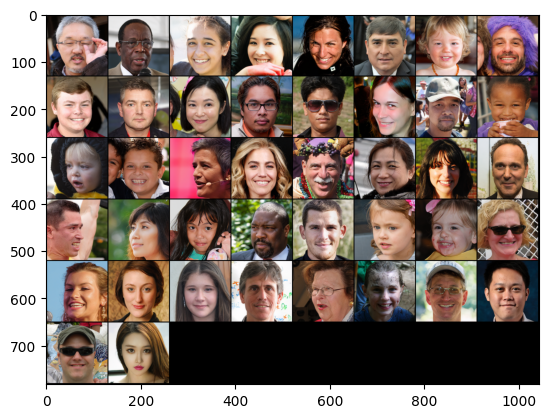

In [32]:
img = next(iter(train_latent_loader))[0]
inputs = img.to("cuda:0", memory_format=torch.contiguous_format).float()

noisy_images = []

decode_and_display(inputs, autoencoder)

# for t in np.linspace(0,99, num=16):
#     noisy_images.append(diffusion.sample_from_forward_process(inputs, int(t))[0])
#
# decode_and_display(torch.stack(noisy_images), autoencoder)

## Generate samples

In [33]:
ddim_sampler = DDIMSampler(latent_diffusion)
shape = (latent_diffusion.channels, latent_diffusion.image_size, latent_diffusion.image_size)
results, intermediates = ddim_sampler.sample(250, 64,shape, None, verbose=False, eta = 1.)

Data shape for DDIM sampling is (64, 4, 32, 32), eta 1.0
Running DDIM Sampling with 250 timesteps


DDIM Sampler:  65%|██████▌   | 163/250 [00:17<00:09,  9.34it/s]


KeyboardInterrupt: 

In [ ]:
image = autoencoder.decode(results)
images_per_row = image.shape[0]
if len(image.shape) ==5:
    image = rearrange(image, 'n b c h w -> b n c h w')
    image = rearrange(image, 'b n c h w -> (b n) c h w')
image = torch.clamp(image, 0, 1)

num_files = len(os.listdir("samples"))
for i, im in enumerate(image):
    torchvision.utils.save_image(im, f"samples/sample_{num_files+i}.png")
grid = torch.permute(torchvision.utils.make_grid(image, nrow=8), (1, 2, 0)).cpu()
plt.imshow(grid)
plt.savefig("test")
plt.show()

## Interpolation

code from "https://github.com/ermongroup/ddim"

In [ ]:
from PIL import Image
ddim_sampler = DDIMSampler(latent_diffusion)
shape = (latent_diffusion.channels, latent_diffusion.image_size, latent_diffusion.image_size)

def slerp(z1, z2, alpha):
    theta = torch.acos(torch.sum(z1 * z2) / (torch.norm(z1) * torch.norm(z2)))
    return (
        torch.sin((1 - alpha) * theta) / torch.sin(theta) * z1
        + torch.sin(alpha * theta) / torch.sin(theta) * z2
    )

z1 = torch.randn(
    8,
    latent_diffusion.channels,
    latent_diffusion.image_size,
    latent_diffusion.image_size,
    device="cuda:0",
)
z2 = torch.randn(
    8,
    latent_diffusion.channels,
    latent_diffusion.image_size,
    latent_diffusion.image_size,
    device="cuda:0",
)

alpha = torch.linspace(0.0, 1.0, steps=10).to(z1.device)
z_ = []
for i in range(alpha.size(0)):
    z_.append(slerp(z1, z2, alpha[i]))

x = rearrange(torch.stack(z_, dim=0), 'i b c h w -> b i c h w')

xs = []

# Hard coded here, modify to your preferences
with torch.no_grad():
    for i in range(0, x.shape[0]):
        row = x[i]
        xs.append(ddim_sampler.sample(200, row.shape[0],shape, None, verbose=False, x_T=row, eta = 0.1)[0])
images = []
for i,x in enumerate(xs):
    image = autoencoder.decode(x)
    images_per_row = image.shape[0]
    if len(image.shape) ==5:
        image = rearrange(image, 'n b c h w -> b n c h w')
        image = rearrange(image, 'b n c h w -> (b n) c h w')
    image = torch.clamp(image, 0, 1)
    grid = torch.permute(torchvision.utils.make_grid(image, nrow=10, padding=0), (1, 2, 0)).cpu()
    images.append(grid)
interps = np.vstack(images)

im = Image.fromarray(interps)
im.save(f"interpolations4.png")
plt.imshow(interps)
plt.show()

## Metrics

In [ ]:
import torch_fidelity

torch_fidelity.calculate_metrics(
    input1='samples',
    input2='../datasets/ffhq/subset128x128',
    cuda=True,
    fid=True,
)